#### Calculate the bolometric light curve of an object..
##### Steps involved

In [9]:
#!/usr/bin/env python
# coding: utf-8
# Author: Anirban Dutta
# =============================================================================#
# Import required packages and modules
# =============================================================================#

import os
import re
import glob
import warnings
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

In [10]:
#=============================================================================#

warnings.simplefilter('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.reset_option('display.float_format')

#=============================================================================#


In [11]:
#=============================================================================#
# Details of the object under study
# =============================================================================#

Object = 'SN 2020sck'       
host = '2MASX J01103497+0206508'            
host_type = 'Host Galaxy'
EB_V_Gal = 0.0256              # Only considering the Galaxy component  https://ned.ipac.caltech.edu/
EB_V_err_Gal = 0.0014          # Schlafly & Finkbeiner 2011
EB_V_Host = 0.00               # No Na-I D lines in HCT spectra observed
EB_V_err_Host = 0.00
JD_offset = 2459000
epoch = 2400000.5
RA = '01:10:34.841'            # https://www.wis-tns.org/object/2020sck
DEC = '+02:06:50.15'
Rv_MW = 3.1                    # The value of total-to-selective absorption
Rv_HG = 3.1
B_max = 2459098.841         # Calculated from spline, MLCS2k2 and SNooPy(E(B-V) model) 
DM = 34.24                     # http://leda.univ-lyon1.fr/ledacat.cgi?o=2MASX%20J01103497%2B0206508%20
DM_err = 0.22                  # 
dm15 = 2.03                    # Calculated from GP-fit
dm15_err = 0.05
z = 0.016

In [12]:
# =============================================================================#
# Calculated in extinction_v1.py script using Fitzpatrick 1999 
# =============================================================================#

R_lambda_MW = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

R_lambda_HG = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45}

# =============================================================================#

In [13]:
# =============================================================================#
# Set Directory Structure
# =============================================================================#

SN_directory = '/home/anirban/2020sck_Reduced/'  # SN results directory

SN_data_UBVRI_ts = '/home/anirban/2020sck_Reduced/Photometry_20210721/OUTPUT_FinalSNMagTemp'
SN_data_UBVRI = SN_directory+'OUTPUT_FinalSNMag'

ZTF_dir = '/home/anirban/2020sck/ZTF_/'
ZTF_data = ZTF_dir +'/ZTF20abwrcmq.csv'

FILTER_directory = '/home/anirban/astromatic/'            # Filter information 
FILTER_data = FILTER_directory+'FILTERS.dat'

SAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/LC_Data'   # Sample of SN Ia 
SNdata_df = pd.read_csv(SAMPLE_directory+'/TypeIa.dat', sep = '\s+', comment = '#')
UVSAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/UV_Data/'
SNdata_df = SNdata_df.set_index('Name')
save_results = '/home/anirban/2020sck/Results/Bolometry_Results/'
# =============================================================================#
# Set Directory Structure
# =============================================================================#

SN_directory = '/home/anirban/2020sck_Reduced/'  # SN results directory

SN_data_UBVRI_ts = SN_directory+'OUTPUT_FinalSNMagTempNew'
SN_data_UBVRI = SN_directory+'OUTPUT_FinalSNMag'

ZTF_dir = '/home/anirban/2020sck/ZTF_/'
ZTF_data = ZTF_dir +'/ZTF20abwrcmq.csv'

FILTER_directory = '/home/anirban/astromatic/'            # Filter information 
FILTER_data = FILTER_directory+'FILTERS.dat'

SAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/LC_Data'   # Sample of SN Ia 
SNdata_df = pd.read_csv(SAMPLE_directory+'/TypeIa.dat', sep = '\s+', comment = '#')
UVSAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/UV_Data/'
SNdata_df = SNdata_df.set_index('Name')

In [14]:
# =============================================================================#
# Read ZTF light curve
# =============================================================================#

col_names = ['candid_str', 'oid', 'candid', 'JD', 'FILTER', 'diffmaglim', 'FMAG', 'magap', 'FERR',
            'sigmagap', 'ra', 'dec', 'sigmara', 'sigmadec', 'isdiffpos', 'distpsnr1', 'sgscore1', 'field',
            'rcid', 'magnr', 'sigmagnr', 'rb', 'magpsf_corr', 'magap_corr', 'sigmapsf_corr', 'sigmaap_corr',
             'has_stamps', 'parent_candid']
            
ztf_lc_df = pd.read_csv(ZTF_data, sep = ',', names = col_names, skiprows=1, engine='python')

ztf_lc_df = ztf_lc_df[['JD', 'FILTER', 'FMAG', 'FERR']].copy()
ztf_lc_df['FILTER'] = ztf_lc_df['FILTER'].replace(1, 'g')
ztf_lc_df['FILTER'] = ztf_lc_df['FILTER'].replace(2, 'r')


In [15]:
# =============================================================================#
# Read the Filters.dat file
# =============================================================================#

filter_df = pd.read_csv(FILTER_data, sep = '\s+', engine = 'python')
filter_df = filter_df.replace('INDEF', np.nan).set_index(['FILTER', 'Marker', 'Color']).astype('float64')
filter_df = filter_df.reset_index().set_index('FILTER')
list_filters = filter_df.index.tolist()
# Filter widths in angstrom
width = np.array([400, 900, 860, 1570, 1500])

In [16]:
# =============================================================================#

# Fundamental Constants which will be used in the model (CGS units)
#--------------------------------------------------------------------------------#

M_sun = 1.989e33          # g
c = 2.99792458e10         # cm/sec
kappa = 0.10              # cm^2/g, kappa_optical 
beta = 13.8               # constant of intergration
v_ph = 5.4e8              # From the Si-II absorption minima at Maxima
M_ej = 1.00*M_sun         # g
E_k = 0.3*M_ej*v_ph**2    # erg

## Equation of tau_m
tau_m = ((2*kappa*M_ej)/(beta*c*v_ph))**0.5
tau_m_days = tau_m/86400.0
#print("Estimated Value of tau_m: %.3f in days"%tau_m_days)
#----------------------------------------------------------------------#

e_Ni = 3.90e10           # (erg/s/g) energy production in 1s by 1g of 56-Ni
e_Co = 6.78e9            # (erg/s/g) energy production in 1s by 1g of 56-Co
                 
tau_Ni = 760340.6        # e-folding time of 56-Ni (8.8 days)
tau_Co = 9685230.0       # e-folding time of 56-Co (111.3 days)
t_Ni = 8.8 
t_Co = 111.8
k_g = 0.03               # cm^2/g

#----------------------------------------------------------------------#
guess_Mni = 0.5          # in units of M_sun
guess_EK = 0.7           # In units of 10^51 erg (foe)
guess_Mej = 1.0          # In units of M_sun
guess_tr = 15            # rise-time in days
#----------------------------------------------------------------------#

In [124]:
# =============================================================================#
# Cell that will have all the important functions of the code
# =============================================================================#


def group_similar_files(text_list, common_text, exceptions = ''):
    
    '''
    Remarks: A function to group similar kind of files in a directory.
    text_list: A text file used to store list of files
    common_text: A string (e.g. *.fits, *.list) used for grouping similar
    kinds of files
    exceptions: string of file name to exclude in grouping
    
    returns: list of grouped files
    '''
    
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exceptions = exceptions.split(',')
        for text in list_exceptions:
            list_files = filter(lambda x: not re.search(text, x), list_files)
        
    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name+'\n')
                
    return list_files  

# -------------------------------------------------------------------------------- #
    
def apparent_mag_df(file_name, tempsub=False):
    
    '''
    Remarks: Creates an apparent magnitude dataframe
    file_name: file containing the SN magnitudes
    (JD, Filter, FMAG, FERR)
    tempsub: Whether the magnitudes are template subtracted
    returns: apparent magnitude dataframe
    '''
    
    appmag_df = pd.read_csv(file_name, sep = '\s+', engine = 'python', comment='#')
    appmag_df = appmag_df.sort_values(by = ['FILTER', 'JD'], kind = 'mergesort')
    appmag_df = appmag_df[['JD','FILTER', 'FMAG', 'FERR']].reset_index(drop = True)
    
    return appmag_df

# -------------------------------------------------------------------------------- #

def jd_to_date(jd, input_fmt='jd', output_fmt='isot'):
    
    '''
    Remarks: Convert jd to date
    jd: Input jd
    input_fmt: format of input ('jd')
    output_fmt: format of output ('iso', 'isot')
    returns: date
    '''
    
    from astropy.time import Time
    times = Time(jd, format=input_fmt)
    date_time = times.to_value(output_fmt)
    date = date_time.split('T')[0]
    
    return date

# -------------------------------------------------------------------------------- #

def calculate_dm(dist, dist_err):
    
    '''
    Remarks:
    dist: Distance
    dist_err: error in the measured distance
    Returns the value of Distance Modulus and Distance Modulus Error.

    The distance modulus is a measure of the distance to an object in magnitude units. 
    An object with a distance modulus of 'zero' is exactly 10 parsecs away. 
    If an object has a negative distance modulus( D.M.), that means 
    it is closer than 10 parsecs and if it has a positive D.M.
    that means it is farther than 10 parsec.

    m-M = 5*log(D)-5
    Here m-M is called the Distance Modulus. 
    
    m : apparent magnitude of the object
    M : absolute magnitude of the object
    D : Distance to the object in parsec

    '''
    
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    
    return [distmod, distmod_err]

# -------------------------------------------------------------------------------- #

def calculate_dist(dist_mod, dist_modd_err):
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_modd_err)/5
    
    return d, d_err

# -------------------------------------------------------------------------------- #

def blackbody_flux(wave, amp, temp):
    
    '''
    Info: Will generate a blackbody flux with a given temp according to the formula.
    wave: wavelength array
    temp: Temperature of the blackbody
    
    Blackbody as a function of wavelength(lamb in wavelength) and temperature(temp in K).
    Returns: erg/cm^2/sec/Steradian/cm

    B_lambda(T) = 2*h*c^2/[lambda^5(exp(hc/(lambda*k*T)-1))]
    B_nu(T) = 2*h*nu^3/[c^2(exp(h*nu/k*T)-1)]
    '''

    flux_lam = amp*blackbody_lambda(in_x = np.asarray(wave), temperature = temp).value
    
    return flux_lam

# -------------------------------------------------------------------------------- #

def cal_flux(mag, err, band, name):
    
    mag = float(mag)
    err = float(err)
    zp = pd.to_numeric(filter_df.loc[band, 'ZeroPoint'])
    #rlambda = pd.to_numeric(filter_df.loc[band, 'RLambda'])
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err'])
        ebv = pd.to_numeric(SNdata_df.loc[name, 'EB_V'])
        ebv_err = pd.to_numeric(SNdata_df.loc[name, 'EB_V_err'])
        
    else:
        dist, dist_err = calculate_dist(DM, DM_err)
        #dist_err = Distance_err
        ebv_MW = EB_V_Gal
        ebv_err_MW = EB_V_err_Gal
        ebv_HG = EB_V_Host
        ebv_err_HG = EB_V_err_Host
        
    ##---------- Distance Modulus ----------##
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    ##--------------------------------------##
    
    ##---------- Absolute Magnitude ----------##
    absmag = mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) - distmod
    absmag_err = (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2 + distmod_err**2)**0.5
    ##--------------------------------------##
    
    ##---------- Flux ----------##
    flux = 10**(-0.4 * (mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) 
                        + zp + 21.10))
    flux_err = 2.303 * flux * (0.4 * (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2))
    ##--------------------------------------##
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------## 
    
    return float(absmag), float(absmag_err), float(flux), float(flux_err), float(luminosity), float(luminosity_err)
        
# -------------------------------------------------------------------------------- #

def cal_lum(flux, name):
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])  # in Mpc
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err']) # in Mpc
        
    else:
        dist = calculate_dist(DM, DM_err)[0]
        dist_err = calculate_dist(DM, DM_err)[1]
        
    """
    For a star(object) with known distance and measured flux, the luminosity is:

    L=flux*4*pi*D^2 
    
    1 parsec = 3.26 ly 
    1 ly = 9.461e17 cm
    1 parsec = 3.086e18 cm

    """
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------##
    
    return float(luminosity), float(luminosity_err) 

# -------------------------------------------------------------------------------- #

def fit_bb(theta, wave):
    
    T = theta
    
    bb =  BlackBody1D(temperature=T*u.K)
    wav = wave * u.AA
    flux = bb(wav).to(FLAM, u.spectral_density(wav))

    return flux.value

def bbody(lam, T, R):
    '''
    Calculate the corresponding blackbody radiance for a set
    of wavelengths given a temperature and radiance.
    Parameters
    ---------------
    lam: Reference wavelengths in Angstroms
    T:   Temperature in Kelvin
    R:   Radius in cm
    Output
    ---------------
    Spectral radiance in units of erg/s/Angstrom
    (calculation and constants checked by Sebastian Gomez)
    '''

    # Planck Constant in cm^2 * g / s
    h = 6.62607E-27
    # Speed of light in cm/s
    c = 2.99792458E10

    # Convert wavelength to cm
    lam_cm = lam * 1E-8

    # Boltzmann Constant in cm^2 * g / s^2 / K
    k_B = 1.38064852E-16

    # Calculate Radiance B_lam, in units of (erg / s) / cm ^ 2 / cm
    exponential = (h * c) / (lam_cm * k_B * T)
    B_lam = ((2 * np.pi * h * c ** 2) / (lam_cm ** 5)) / (np.exp(exponential) - 1)

    # Multiply by the surface area
    A = 4*np.pi*R**2

    # Output radiance in units of (erg / s) / Angstrom
    Radiance = B_lam * A / 1E8

    return Radiance

def sn_abs_df(sn_df, name):
    
    '''
    Info: 
    data: the SN-dataframe under study.
    B_max: maximum magnitude in B-band.
    
    Returns: the absolute magnitude dataframe along with separate dataframes for 
    total, B, V, R, I, U
    Remarks: Future version will include itertuples.
    
    '''
    
    #sn_df = pd.read_csv(data, sep = '\s+', engine = 'python')
    #sn_df['Date'] = sn_df['JD'].apply(lambda x: jd_2_gcal(x))
    sn_df['Phase'] = (sn_df['JD'] - B_max)/(1 + z)
    sn_df['FILTER'] = sn_df['FILTER'].apply(lambda x: x if 'UV' not in x else x.lower())

    for index, band in sn_df['FILTER'].items():
        if name != '':
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = name)
        else:
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = '')
        sn_df.loc[index, 'AbsMag'] = magflux[0]
        sn_df.loc[index, 'AbsErr'] = magflux[1]
        sn_df.loc[index, 'Flux'] = magflux[2]
        sn_df.loc[index, 'FluxErr'] = magflux[3]
        sn_df.loc[index, 'Lum'] = magflux[4]
        sn_df.loc[index, 'Lum_Err'] = magflux[5]
        
    # returns the abs-mag dataframe for U-band
    sn_df_U = sn_df[sn_df['FILTER'] == 'U'].copy()
    sn_df_U.Phase = pd.to_numeric(sn_df_U.Phase)
    sn_df_U.AbsMag = pd.to_numeric(sn_df_U.AbsMag)

    
    # returns the abs-mag dataframe for B-band
    sn_df_B = sn_df[sn_df['FILTER'] == 'B'].copy()
    sn_df_B.Phase = pd.to_numeric(sn_df_B.Phase)
    sn_df_B.AbsMag = pd.to_numeric(sn_df_B.AbsMag)

    # returns the abs-mag dataframe for V-band
    sn_df_V = sn_df[sn_df['FILTER'] == 'V'].copy()
    sn_df_V.Phase = pd.to_numeric(sn_df.Phase)
    sn_df_V.AbsMag = pd.to_numeric(sn_df.AbsMag)
    
    # returns the abs-mag dataframe for R-band
    sn_df_R = sn_df[sn_df['FILTER'] == 'R'].copy()
    sn_df_R.Phase = pd.to_numeric(sn_df.Phase)
    sn_df_R.AbsMag = pd.to_numeric(sn_df.AbsMag)
    
    # returns the abs-mag dataframe for I-band
    sn_df_I = sn_df[sn_df['FILTER'] == 'I'].copy()
    sn_df_I.Phase = pd.to_numeric(sn_df.Phase)
    sn_df_I.AbsMag = pd.to_numeric(sn_df.AbsMag)
    
    return [sn_df, sn_df_B, sn_df_V, sn_df_R, sn_df_I, sn_df_U]


def sn_abs_df_ztf(sn_df, name):
    
    
    '''
    Info: 
    data: the SN-dataframe under study.
    B_max: maximum magnitude in B-band.
    
    Returns: the absolute magnitude dataframe along with separate dataframes for 
    total, B, V, R, I, U
    Remarks: Future version will include itertuples.
    
    '''
    
    #sn_df = pd.read_csv(data, sep = '\s+', engine = 'python')
    #sn_df['Date'] = sn_df['JD'].apply(lambda x: jd_2_gcal(x))
    b_max = B_max - epoch
    sn_df['Phase'] = (sn_df['JD'] - b_max)/(1 + z)
    sn_df['FILTER'] = sn_df['FILTER'].apply(lambda x: x if 'UV' not in x else x.lower())

    for index, band in sn_df['FILTER'].items():
        if name != '':
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = name)
        else:
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = '')
        sn_df.loc[index, 'AbsMag'] = magflux[0]
        sn_df.loc[index, 'AbsErr'] = magflux[1]
        sn_df.loc[index, 'Flux'] = magflux[2]
        sn_df.loc[index, 'FluxErr'] = magflux[3]
        sn_df.loc[index, 'Lum'] = magflux[4]
        sn_df.loc[index, 'Lum_Err'] = magflux[5]
        
    # returns the abs-mag dataframe for g-band
    sn_df_g = sn_df[sn_df['FILTER'] == 'g'].copy()
    sn_df_g.Phase = pd.to_numeric(sn_df_g.Phase)
    sn_df_g.AbsMag = pd.to_numeric(sn_df_g.AbsMag)

    
    # returns the abs-mag dataframe for r-band
    sn_df_r = sn_df[sn_df['FILTER'] == 'r'].copy()
    sn_df_r.Phase = pd.to_numeric(sn_df_r.Phase)
    sn_df_r.AbsMag = pd.to_numeric(sn_df_r.AbsMag)
    
    
    return [sn_df, sn_df_g, sn_df_r]

# -------------------------------------------------------------------------------- #

def plot_params(band, ax, ml_x, mil_x, ml_y, mil_y, invert=False):
    
    '''
    Remarks: Plotting paramaters
    band : Band to plot.
    ax : define axes of the figure.
    ml_x : x-axis major locator.
    mil_x : x-axis minor locator.
    ml_y : y-axis major locator.
    mil_y : y-axis minor locator.
    invert : invert the y-axis or not
    
    Returns: None
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 8, width = 1.5, labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 4, width = 0.8, labelsize = 12)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))

# -------------------------------------------------------------------------------- #

def find_local_maxima(arr, n):
    
    '''
    Remarks: Finds the minima
    arr: array to be used as input.
    n: length of the array.
    
    returns: index of minima
    '''
    
    idx_min = []
    if (arr[0] > arr[1]):
        idx_min.append(0)
    for i in range(1, n-1):
        if (arr[i-1] < arr[i] > arr[i+1]):
            idx_min.append(i)
    if (arr[-1] > arr[-2]):
        idx_min.append(n-1)
        
    return idx_min

def columnwise_to_rowwise(data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
    list_del = ['Date', 'Epoch', 'Seeing', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
           'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope']
    
    if 'Epoch' in data_df.columns.values:
        data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    #if 'Phase' not in data_df.columns:
    #    data_df['Phase'] = data_df['JD'] - B_max
        
    
    data_df = data_df.set_index('JD')
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'JD'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['JD', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df

def interpolate_lc(df, amp=None, scale=None, diff_deg=None,
                  plot=False, save_pred=False):
    
    '''
    Remarks: Interpolate Light Curve with Gaussian Process
    Regression.
    df: SN LC dataframe
    band: Filter 
    amp: amplitude of kernel (typically set by the amount by which the function
    varies.default is set by the standard deviation of the magnitude.)
    scale: scale over which the function typically varies.(default is 10)
    diff_deg: degree of differentiability. Controls the smoothness of the function.
    plot: Bool to plot the results
    save_pred: Bool to save the predictions as pickle file for later use.
    
    returns: LC parameters after fit
    (jd, magnitude, magnitude_err) at maximum.
    
    
    '''
    
    #band_df = df[df['FILTER']==band].copy()
    
    x = np.ravel(df['JD'].values)    # x-value
    y = np.ravel(df['Total_LogLum'].values)  # y-value
    #print (y)
    yerr = np.ravel(df['Total_LogLum_Err'].values) # error on y value
    
    mean = lambda x: x*0 + np.median(y)  # construction of the mean function
    #print (mean(x))
    
    if amp is None:
        amp = np.std(y - mean(x))
    elif amp == 'LC':
        amp = np.std(y)
    if scale is None:
        scale = 10
    if diff_deg is None:
        diff_deg = 1
        
    # Define the kernel
    # A constant kernel plus the matern kernel
    
    kernel = ConstantKernel(amp, constant_value_bounds='fixed') * \
    Matern(length_scale=scale, length_scale_bounds='fixed', nu=diff_deg+0.5)
    
    # Implement Gaussian Process Regressor
    X = np.array([x]).T
    Y = y - mean(x) 
    #Y = y
    gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr**2).fit(X, Y)
    # Fit the gp model
    
    ## Make predictions at points
    list_phase = np.atleast_2d(np.linspace(df['JD'].min()-3, df['JD'].max(), 1000)).T
    #print (list_phase)
    
    ## Make predictions
    x_pred = np.ravel(list_phase)
    res, sig_pred = gp.predict(list_phase, return_std=True)
    #print (res)
    res += mean(x_pred)
    
    # Calculate the maxima of the LC and the jd for the maxima.
    n = len(res)
    idx_minima = find_local_maxima(res, n)
    #print (res)
    #print (type(res))
    ## I-band will have a secondary maxima
    ## Need to modify this part of the code in an optimum way.
    #if band != 'I':
    #    jd_max = x_pred[idx_minima[0]]
    #    mag_max = res[idx_minima[0]]
    #    err_max = sig_pred[idx_minima[0]]
    #    jd_15 = jd_max + 15
    #    res_15, err_15 = gp.predict(np.atleast_2d(jd_15).T, return_std=True)
    #    mag_15 = res_15 + mean(jd_15)
    #    dm15 = mag_15 - mag_max
    #    dm15_err = np.sqrt(err_max**2 + err_15**2)
    #else:
    jd_max = x_pred[idx_minima[0]]
    mag_max = res[idx_minima[0]]
    err_max = sig_pred[idx_minima[0]]
    lum_max = 10**mag_max
    lum_err_max = (err_max*lum_max)/0.434
        #jd_15 = jd_max + 15
        #res_15, err_15 = gp.predict(np.atleast_2d(jd_15).T, return_std=True)
        #mag_15 = res_15 + mean(jd_15)
        #dm15 = mag_15 - mag_max
        #dm15_err = np.sqrt(err_max**2 + err_15**2)
        
        #jd_max2 = x_pred[idx_minima[1]]
        #mag_max2 = res[idx_minima[1]]
        #err_max2 = sig_pred[idx_minima[1]]  
    
    ## Make plots of predictions and show confidence intervals
    if plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        #ax.invert_yaxis()
        
        ax.plot(x_pred, res, 'k-', label='Prediction')
        ax.errorbar(x, y, yerr, fmt='r.', ms=10, 
                    label='Observation')
        #if band !='I':
        #    ax.plot(jd_max, mag_max, '*', color='blue', ms=12)
        #else:
        ax.plot(jd_max, mag_max, '*', color='blue', ms=12)
            #ax.plot(jd_max2, mag_max2, '*', color='blue', ms=12)
        ax.fill_between(x_pred, res-sig_pred, res+sig_pred,
               alpha = 0.3, fc = 'blue', ec='None', label = '1-sigma')
        
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize = 15)
            #tick.label1.set_fontweight('bold')
    
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize = 15)
            #tick.label1.set_fontweight('bold')
        ax.legend()
        
    # Save the predictions as pickle file
    if save_pred:
        interp_df = pd.DataFrame(list(zip(x_pred, res, sig_pred)), columns=['Phase', 'Lum', 'Lum_Err'])
        output_filename = save_results+'interp_'+str(band)+'.pkl'
        if os.path.exists(output_filename):
            os.remove(output_filename)
        interp_df.to_pickle(output_filename)
        
    #if band != 'I':
    #    return (x_pred, res, sig_pred, jd_max, mag_max, err_max, jd_15, 
    #            mag_15, err_15, dm15, dm15_err)
    #else:
    return (x_pred, res, sig_pred, jd_max, lum_max, lum_err_max)
    
def predict_val(df, x_pred, band, amp=None, scale=None, diff_deg=None):
    
    band_df = df[df['FILTER']==band].copy()
    
    x = np.ravel(band_df['JD'].values)    # x-value
    y = np.ravel(float(band_df['FMAG'].values))  # y-value
    yerr = np.ravel(float(band_df['FERR'].values)) # error on y value
    
    mean = lambda x: x*0 + np.median(y)  # construction of the mean function
    
    if amp is None:
        amp = np.std(y - mean(x))
    elif amp == 'LC':
        amp = np.std(y)
    if scale is None:
        scale = 10
    if diff_deg is None:
        diff_deg = 1
        
    # Define the kernel
    # A constant kernel plus the matern kernel
    
    kernel = ConstantKernel(amp, constant_value_bounds='fixed') * \
        Matern(length_scale=scale, length_scale_bounds='fixed', nu=diff_deg+0.5)
    
    # Implement Gaussian Process Regressor
    X = np.array([x]).T
    Y = y - mean(x) 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr**2).fit(X, Y)
    # Fit the gp model
    
    ## Make predictions at points
    #list_jd = np.atleast_2d(np.linspace(band_df['JD'].min()-8, band_df['JD'].max(), 1000)).T
    
    ## Make predictions
    res, sig_pred = gp.predict(np.atleast_2d(x_pred).T, return_std=True)
    res += mean(x_pred)
    
    return res, sig_pred

def construct_bol(obs_df, plot=False, uv_ir=False, temp=False):
    
    '''
    obs_df : Observed DataFrame
    model_df : Model Dataframe from where to draw interpolation.
    plot: Bool (True/False) Plots the data.
    uv_ir: Bool (True/False) Whether to add the UV-IR contribution or not.
    '''
    
    obs_df['JD'] = obs_df['JD'].round(0)
    
    pivot_mag_df = pd.pivot_table(data=obs_df, values='FMAG', index='JD', columns='FILTER')
    #pivot_mag_df = pivot_mag_df.drop(['uvb', 'uvu', 'uvv', 'uvw1', 'uvm2', 'uvw2'], axis = 1) 
    pivot_mag_df = pivot_mag_df.replace(np.nan, 99.99)
    
    pivot_err_df = pd.pivot_table(data=obs_df, values='FERR', index='JD', columns='FILTER')
    #pivot_err_df = pivot_err_df.drop(['uvb', 'uvu', 'uvv', 'uvw1', 'uvm2', 'uvw2'], axis=1)
    pivot_err_df = pivot_err_df.replace(np.nan, 99.99)
    
    dict_mag = {}   
    for index, band in pivot_mag_df.iterrows():
        if index not in dict_mag.keys():
            dict_mag[index] = {}
            for filt, value in band.iteritems():
                if filt not in dict_mag[index]:
                    #if index < 2458155:
                    if value == 99.99:
                        dict_mag[index][filt] = float(predict_val(obs_df, index, filt, amp=None,
                                                   scale=30, diff_deg=2)[0])
                    else:
                        dict_mag[index][filt] = value
                    #elif (index > 2458159) & (value == 99.99):
                    #    dict_mag[index][filt] = np.nan
                    #else:
                     #   dict_mag[index][filt] = value
    
    mag_df = pd.DataFrame(dict_mag).T
    mag_df = mag_df.round(3)
                        
    dict_err = {}   
    for index, band in pivot_err_df.iterrows():
        if index not in dict_err.keys():
            dict_err[index] = {}
            for filt, value in band.iteritems():
                if filt not in dict_err[index]:
                    #if index < 2458155:
                    if value == 99.99:
                        dict_err[index][filt] = float(predict_val(obs_df, index, filt, amp=None,
                                                   scale=30, diff_deg=2)[1])
                    else:
                        dict_err[index][filt] = value
                    #elif (index > 2458155) & (value == 99.99):
                    #    dict_err[index][filt] = np.nan
                    #else:
                    #    dict_err[index][filt] = value
                    
    
    err_df = pd.DataFrame(dict_err).T
    err_df = err_df.round(3)
    err_df = err_df.rename(columns=lambda x: x+'Err')
    
    final_df = pd.concat([mag_df, err_df], axis=1)
    
    final_df.index.name = 'JD'
    final_df = final_df.reset_index()
    final_df = final_df[['JD', 'B', 'BErr', 'I', 'IErr', 'R', 'RErr', 'U', 'UErr', 
                    'V', 'VErr']]
    
    output_df = columnwise_to_rowwise(data_df=final_df)
    flux_df = sn_abs_df(output_df, name='')[0]
    
    flux_df = flux_df.set_index('JD')
    dict_flux = {}
    for index, row in flux_df.iterrows():
        if index not in dict_flux.keys():
            dict_flux[index] = {}
        if row['FILTER'] not in dict_flux[index]:
            dict_flux[index][row['FILTER']] = row['Lum']
            dict_flux[index][row['FILTER']+'Err'] = row['Lum_Err']
            
    flux_df_1 = pd.DataFrame(dict_flux).T
    flux_df_1.index.name = 'JD'
    flux_df_1 = flux_df_1.reset_index()
    
    dict_bol = {}
    for (day, dict_date) in dict_flux.items():
        if day not in dict_bol.keys():
            dict_bol[day] = {}
        for (band, flux) in dict_date.items():
            if 'Err' not in band:
                dict_bol[day][filter_df.loc[band, 'CentreWave']] = flux
            else:
                dict_bol[day][str(filter_df.loc[band.rstrip('Err'), 'CentreWave'])+'Err'] = flux
                        
    bol_df = pd.DataFrame(dict_bol).T
    bol_df.index.name = 'JD'
    bol_df = bol_df.T
    
    
    from scipy.interpolate import CubicSpline
    dict_lum = {}
    
    if os.path.exists('lum_sed.pdf'):
        os.remove('lum_sed.pdf')
    
    pp = PdfPages(save_results+'lum_sed.pdf')
    for jd in bol_df.columns.values:
    
        series = bol_df[jd].dropna()
        mag = series.loc[[x for x in list(series.index) if type(x) != str]]
        mag = mag.sort_index(ascending=True)
        err = series.loc[[x for x in list(series.index) if type(x) == str]]
        err = err.sort_index(ascending=True)
        
        index_list = mag.index.values.tolist()
        values_list = mag.values.tolist()
        err_list = err.values.tolist()
        err_array = np.array(err_list)
    
        #print (jd, index_list, values_list, err_list)
        #if jd < 2458155:
        #    wave_data = np.linspace(3200, 9500, 1000)
        #else:
        #if jd < 2459150:
        wave_data = np.linspace(3000, 9500, 1000)
        #else:
        #wave_data = np.linspace(5000, 9500, 1000)
        spline = CubicSpline(index_list, values_list, bc_type = 'natural', 
                                extrapolate = True)
        
        flux_data = spline(wave_data)
        flux_data[flux_data < 0] = 0
    
        opt_lum = np.trapz(flux_data, wave_data)  
        opt_lum_err = np.sqrt(np.sum((width*err_array)**2))
        # Add UV contribution to total flux at each epoch
        #phase = jd - 2458066 ## 
        
        #total_flux = opt_flux + (add_uv_ir(phase)[0] * opt_flux) + (add_uv_ir(phase)[1] * opt_flux)
        
        #if uv_ir:
        #    lum, lum_err = cal_lum(total_flux, name='')
        #else:
        #    lum, lum_err = cal_lum(opt_flux, name='')
            
        if temp:
            popt, pcov = curve_fit(bbody, xdata=index_list, ydata=values_list,
                                  sigma=err_list, p0=[10000, 1e15])
            
            T = popt[0]
            R = popt[1]
            T_err = np.sqrt(np.diag(pcov))[0]
            R_err = np.sqrt(np.diag(pcov))[1]
        #wave_uv = np.arange(1000, 3000)
        #bb_flux_uv = fit_bb(wave_uv, *popt)
        
        
        #flux_uv = np.trapz(bb_flux_uv, wave_uv)
        #flux_ir = np.trapz(bb_flux_ir, wave_ir)
        #print (flux_ir)
        #wave_bb = np.arange(1000, 25000)
        #bb_flux = fit_bb(wave_bb, *popt)
        #flux_bb = np.trapz(bb_flux, wave_bb)
        #total_flux = opt_flux + flux_bb
        #total_lum = cal_lum(total_flux, name='')[0]
        if uv_ir:
                            
            wave_uv = np.arange(1000, 2999)
            bb_flux_uv = bbody(wave_uv, *popt)
            bb_lum_uv = np.trapz(bb_flux_uv, wave_uv)
            bb_lum_uv_err = bb_lum_uv * np.sqrt((2*R_err/R)**2+(4*T_err/T)**2)
                            
            wave_ir = np.arange(9501, 25000)
            bb_flux_ir = bbody(wave_ir, *popt)
            bb_lum_ir = np.trapz(bb_flux_ir, wave_ir)
            bb_lum_ir_err = bb_lum_ir * np.sqrt((2*R_err/R)**2+(4*T_err/T)**2)
            
            total_lum = bb_lum_uv + opt_lum + bb_lum_ir
            total_lum_err = np.sqrt(bb_lum_uv_err**2 + opt_lum_err**2 + bb_lum_ir_err**2)
            
            #bb_lum = 4*np.pi*popt[1]**2*5.67e-5*popt[0]**4
            #bb_lum_err = bb_lum*np.sqrt((2*np.sqrt(np.diag(pcov)[1])/popt[1])**2+(4*np.sqrt(np.diag(pcov)[0])/popt[0])**2)
            
            
        
        dict_lum[jd] = {}
        dict_lum[jd]['Date'] = jd_to_date(jd)
        dict_lum[jd]['Phase'] = jd - B_max
        dict_lum[jd]['Lum'] = opt_lum
        dict_lum[jd]['Lum_Err'] = opt_lum_err
        dict_lum[jd]['LogLum'] = np.log10(opt_lum)
        if uv_ir:
            dict_lum[jd]['Total_Lum'] = total_lum
            dict_lum[jd]['Total_LogLum'] = np.log10(total_lum)
            dict_lum[jd]['Total_Lum_Err'] = total_lum_err
        if temp:
            dict_lum[jd]['Temp'] = T
            dict_lum[jd]['TempErr'] = T_err
            dict_lum[jd]['Radius'] = R
            dict_lum[jd]['Radius_Err'] = R_err
            #dict_lum[jd]['Total_Lum'] = total_lum
    
        
        if plot:
            fig = plt.figure(figsize = (6,6))
            ax = fig.add_subplot(111)
            ax.plot(mag.index.values, mag.values, 'o', label = 'DataPoints')
            ax.plot(wave_data, spline(wave_data), '-', label = 'CubicSpline')
            if temp:
                wave_data = np.arange(1000, 25000)
                ax.plot(wave_data, bbody(wave_data, *popt), 
                        label=r'$\rm Temp=%.1f$'%popt[0])
            ax.set_title(jd)
            ax.legend()
            pp.savefig(fig)
            
        lum_df = pd.DataFrame(dict_lum).T
        lum_df.index.name = 'JD'
        lum_df = lum_df.reset_index()
        
    lum_df['Lum'] = lum_df['Lum'].apply(lambda x: '{:.2e}'.format(x))
    lum_df['Lum_Err'] = lum_df['Lum_Err'].apply(lambda x: '{:.2e}'.format(x))
    lum_df['Total_Lum'] = lum_df['Total_Lum'].apply(lambda x: '{:.2e}'.format(x))
    lum_df['Total_Lum_Err'] = lum_df['Total_Lum_Err'].apply(lambda x: '{:.2e}'.format(x))
    lum_df['Radius'] = lum_df['Radius'].apply(lambda x: '{:.2e}'.format(x))
    lum_df['Radius_Err'] = lum_df['Radius_Err'].apply(lambda x: '{:.2e}'.format(x))
        
    fig1 = plt.figure(figsize = (6,6))
    ax1 = fig1.add_subplot(111)
    ax1.plot(lum_df['Phase'], lum_df['Temp'], color='crimson', ls=' ',
             marker='o', label = 'Temperature')
    ax1.set_xlabel('Time since B-band maxima [days]', fontsize=12)
    ax1.set_ylabel('Temperature [K]')
    pp.savefig(fig1)
    
    fig2 = plt.figure(figsize = (6,6))
    ax2 = fig2.add_subplot(111)
    lum_df['Radius'] = pd.to_numeric(lum_df['Radius'])
    ax2.plot(lum_df['Phase'], lum_df['Radius'], color='crimson', ls=' ', 
             marker='o', label = 'Radius')
    ax2.set_xlabel('Time since B-band maxima [days]', fontsize=12)
    ax2.set_ylabel('Radius [cm]')
    pp.savefig(fig2)
    
    pp.close()
        
    return lum_df


def Rad_Diffusion(theta, jd_list): 
    
    '''
    Info: Fits the early part of the Light Curve.
    theta: array of fit-parameters.
    jd_list: list of jd from a clipped dataframe
    Returns: Luminosity (erg/s)
    Parameters to fit are the Nickel-56 mass, ejecta-mass and rise-time of
    the bolometric LC.
    m_ni = Nickel mass in terms of M_solar.
    t_d = effective LC timescale (the mean of the hydrodynamical and diffusion timescales.)
    (1-exp(-At^-2)) accounts for gamma-ray leakage, where large A means that all gamma-rays and
    positrons are trapped.
    jd_exp = time since explosion in jd. 
    '''
    
    from scipy.integrate import quad
    m_ni, t_d, t_g, jd_exp = theta
    
    phase_list = jd_list - jd_exp                        
    time_list = phase_list*86400.0                     
    
    tau_m = t_d * 86400
    
        
    x = time_list/tau_m
    y = tau_m/(2*tau_Ni)
    s = (tau_m*(tau_Co - tau_Ni)/(2*tau_Co*tau_Ni))
    
    def funcA(z, y):
        return 2*z*np.exp((-2*z*y)+z**2)
    def funcB(z, y, s):
        return 2*z*np.exp((-2*z*y)+(2*z*s)+(z**2))
     
    #for index, time in enumerate(x):
    #    lph[index] = M_sun*m_ni*np.exp(-time**2)*((e_Ni-e_Co)*quad(funcA, 0, time, args=(y,))[0]+ \
    #                                             e_Co*quad(funcB, 0, time, args=(y, s))[0])* \
    #                                              (1 - np.exp(A*))
    a = np.array([quad(funcA, 0, xi, args=(y,))[0] for xi in x])
    aerr = np.array([quad(funcA, 0, xi, args=(y,))[1] for xi in x])

    # integrate B(z)dz from 0 to x
    b = np.array([quad(funcB, 0, xi, args=(y, s))[0] for xi in x])
    berr = np.array([quad(funcB, 0, xi, args=(y, s))[1] for xi in x])
    
    try:
        lum = m_ni * M_sun * np.exp(-x**2) * ((e_Ni-e_Co)*a + e_Co*b) * (1 - np.exp(-t_g**2/phase_list**2))
    except ValueError:
        lum = -np.inf
    
    return lum

def log_likelihood(theta, x, y, y_err):
    
    param = theta
        
    lum = Rad_Diffusion(param, x)
    diff = y - lum
    sigma = y_err**2
    
    try:
        LnLike = -0.5*np.sum(diff**2/sigma)
    except ValueError:
        LnLike = -np.inf
    
    return LnLike

def log_prior(theta):
    
    m_ni, t_d, A, jd_exp = theta
    if m_ni > 0 and t_d > 0 and 2459082 < jd_exp < 2459090:
        try:
            return 0
        except ValueError:
            return -np.inf
    else:
        return -np.inf


def log_prob(theta, log_prior, x, y, y_err):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    try:
        value = lp+log_likelihood(theta, x, y, y_err)
    except ValueError:
        value = -np.inf
    
    #return lp + log_likelihood(theta, x, y, y_err)
    return value


def run_MCMC(log_prob, log_prior, soln, df, t, l, l_err, ndim, nwalkers, niter, progress=True):
    
    import emcee

    
    x = df[t].values
    y = df[l].values 
    y_err = df[l_err].values
    
    p0 = [soln + 1e-4*np.random.randn(ndim) for _ in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=([log_prior, x, y, y_err]))
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=progress)
    
    return [sampler, pos, prob, state]

def run_walkers(sampler, put_label, axes, ndim):


    samples = sampler.get_chain()
    new_samples = sampler.flatchain
    labels = put_label
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "", alpha=0.3)
        #ax.plot(samples[i], 'k', alpha =0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    new_max = new_samples[np.argmax(sampler.flatlnprobability)]
    
    return new_max

def corner_plot(sampler, put_label, soln, ndim):
    
    import corner
    #samples = sampler.chain[:, :, :].reshape((-1, ndim))
    
    #m_ni = soln[0] # in M_solar
    #t_d = soln[1]  # in days
    #t_gamma = np.sqrt(soln[2])  # in days
    #t_RB = soln[3] - B_max     # in days
    samples = sampler[0].flatchain
    #m_ni = sampler[:, :, 0].reshape(-1)
    #t_d = samplesr[:, :, 1].reshape(-1)
    #t_g = np.sqrt(sampler[:, :, 2].reshape(-1))
    #t_RB = sampler[:, :, 3].reshape(-1) - B_maxnp.sqrt(np.diag(covar))
    
    #new_samples = np.vstack([m_ni, t_d, t_g, t_RB]).T
    
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=50, direction='in', length=10, width=5)
        
    labels = put_label
    fig = corner.corner(samples, show_titles = True,
                   plot_datapoints = True, quantiles = [0.16, 0.5, 0.84], labels = labels,
                   title_kwargs = {'fontsize': 22, 'fontweight': 'bold'}, 
                   plot_contours = True, color='navy', reverse=False, fig=fig,
                       labelpad=0.05)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    
    fig.savefig(save_results+'Corner.pdf', dpi=500, 
                bbox_inches='tight')

def results_MCMC(sampler, put_label,  params, ndim):
    
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    param = params
    labels = put_label
    for i in range(len(param)):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        #display(Math(txt))    
    
def run_minimizer(log_likelihood, df, x, y, y_err, param, seed):
    
    from scipy.optimize import minimize
    data = (df[x].values, df[y].values, df[y_err].values)
    np.random.seed(seed)
    nl1 = lambda *args: -log_likelihood(*args)
    initial = np.array(param)
    soln = minimize(nl1, initial, args = data)
    fit_values = soln.x    
    return fit_values

def cal_chisq(params, data_df):
    
    best_fit = Rad_Diffusion(params, data_df['JD'])
    chisq = np.sum((best_fit - data_df['Lum'])**2/data_df['Lum_Err']**2)
    
    return chisq

In [106]:
object_df_UBVRI_ts = apparent_mag_df(SN_data_UBVRI_ts)

abs_df = sn_abs_df(object_df_UBVRI_ts, name='')[0]
clipped_abs_df = abs_df[(abs_df['JD'] <= 2459130)].copy()
#lum_df_opt = construct_bol(abs_df, plot=True, temp=False)
print (abs_df.dtypes) 

JD         float64
FILTER      object
FMAG       float64
FERR       float64
Phase      float64
AbsMag     float64
AbsErr     float64
Flux       float64
FluxErr    float64
Lum        float64
Lum_Err    float64
dtype: object


In [19]:
pivot_mag_df = pd.pivot_table(data=abs_df, values='FMAG', index='JD', columns='FILTER')

In [20]:
#pivot_mag_df

In [21]:
lum_df_opt = construct_bol(clipped_abs_df, plot=True, uv_ir=True, temp=True)
lum_df_opt.to_csv(save_results+'bolometry.dat', sep=' ', float_format='%.3f')

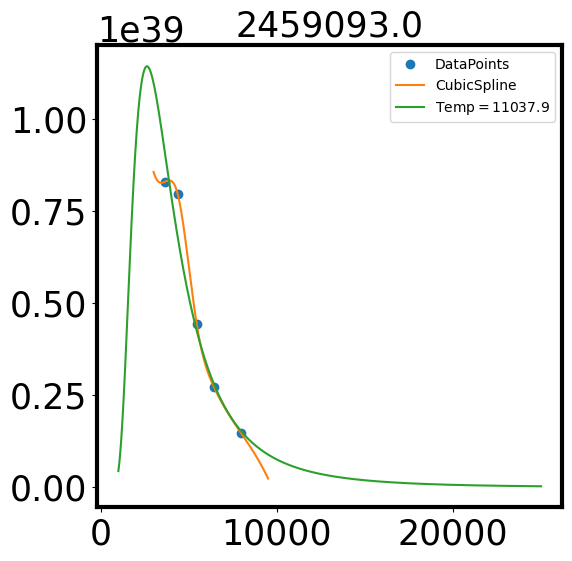

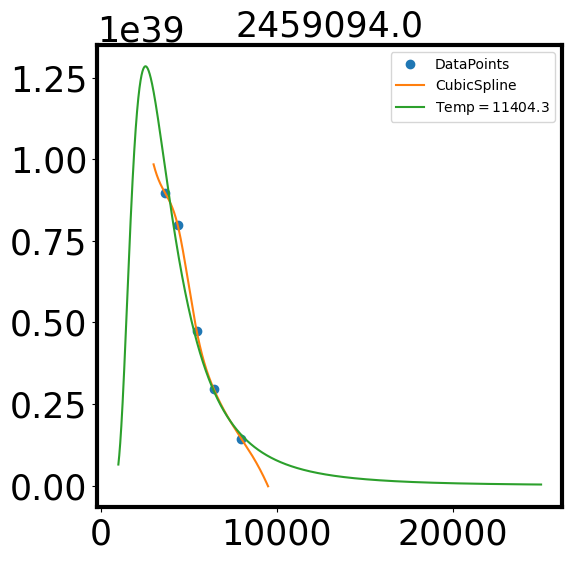

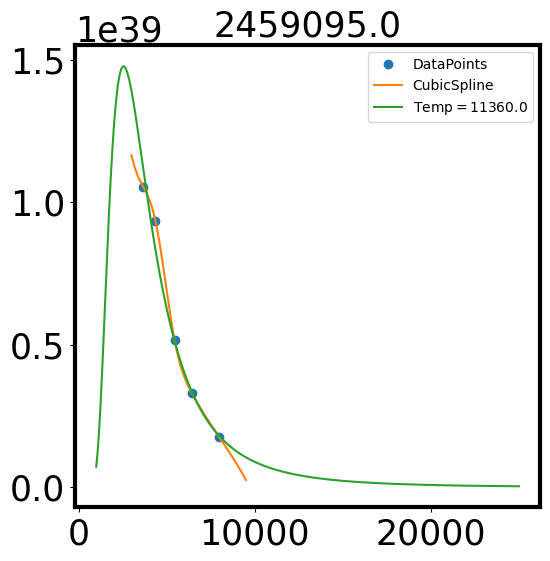

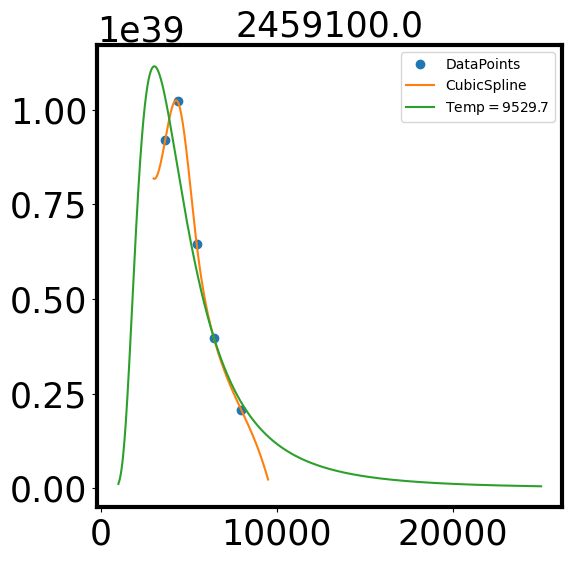

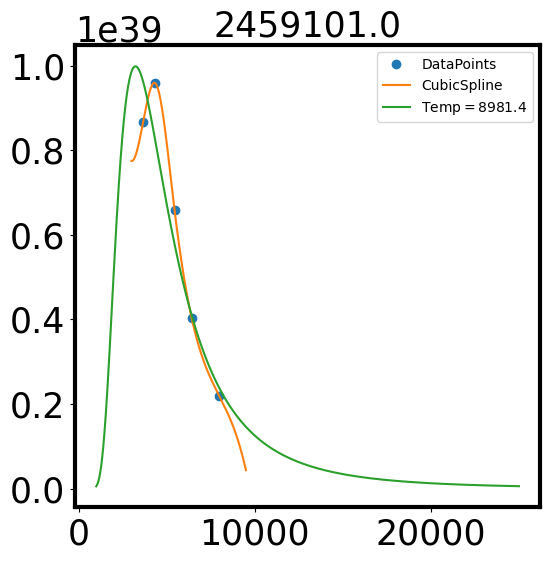

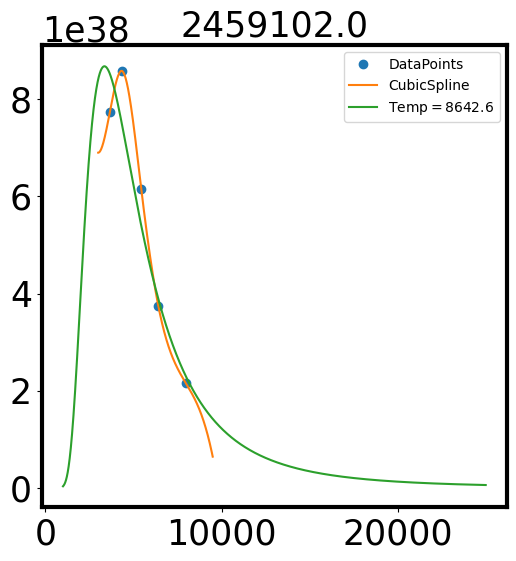

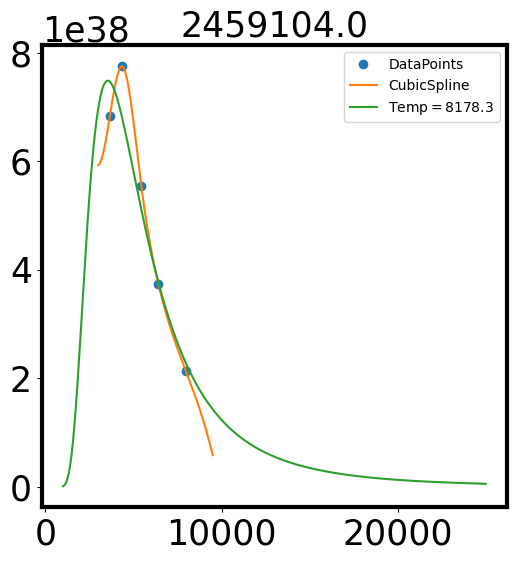

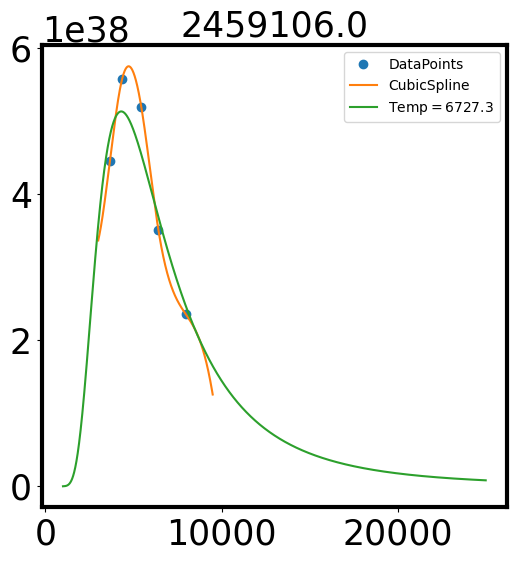

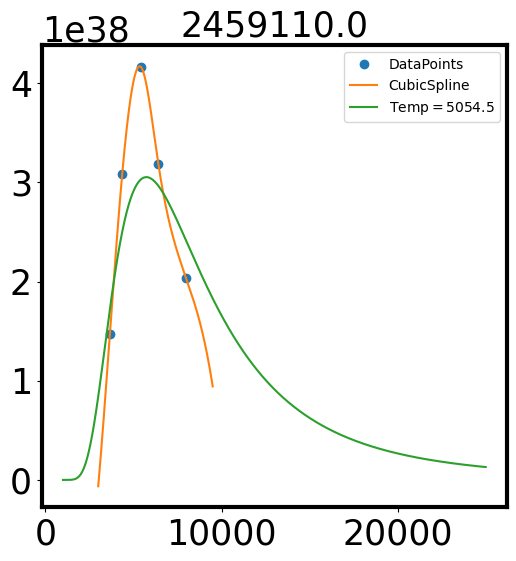

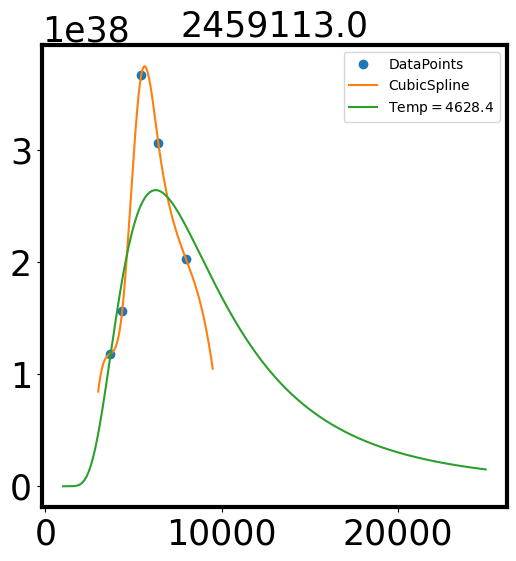

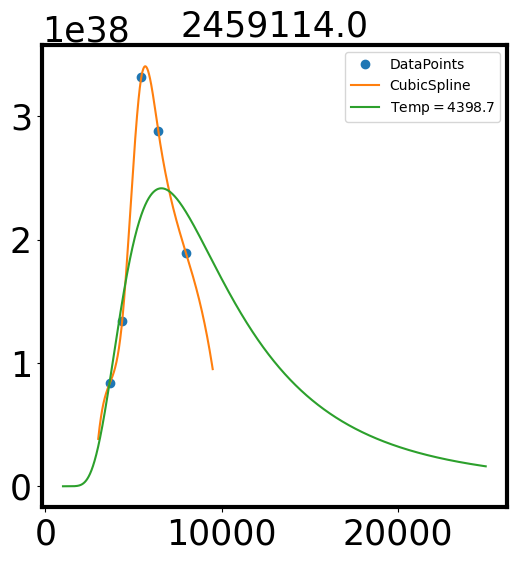

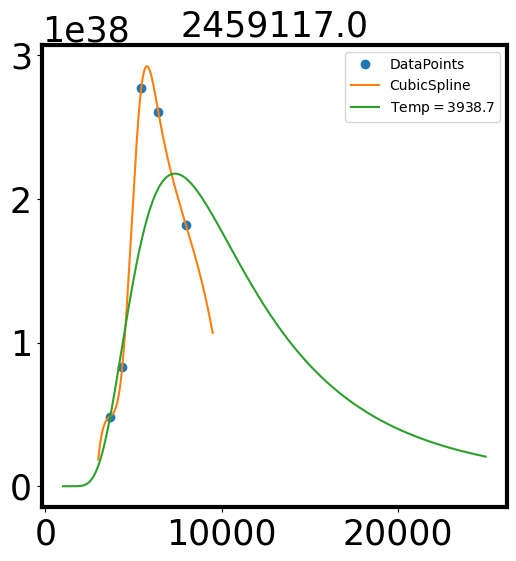

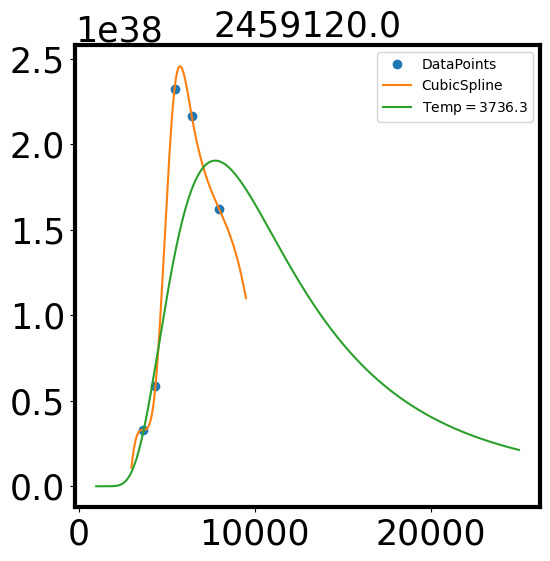

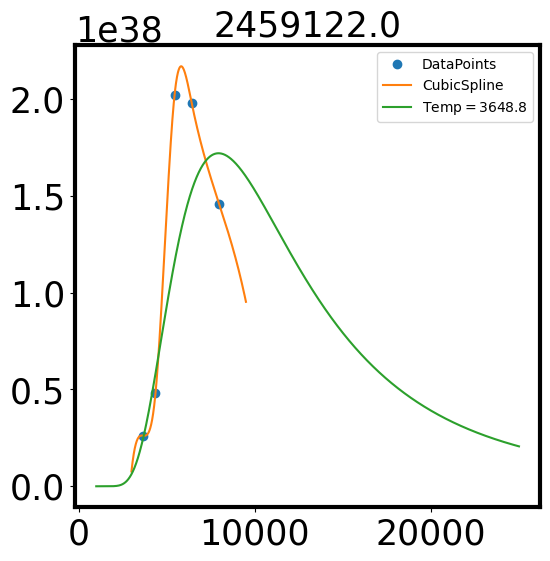

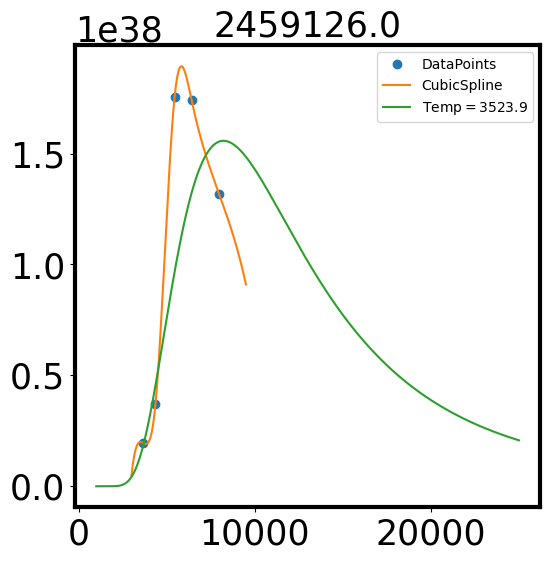

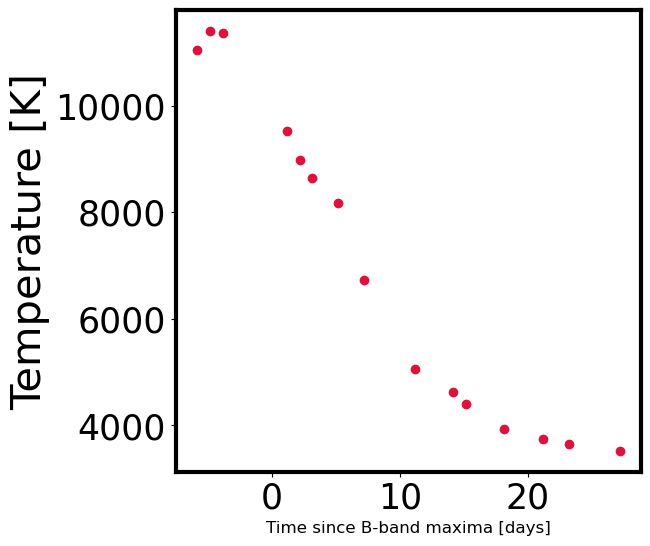

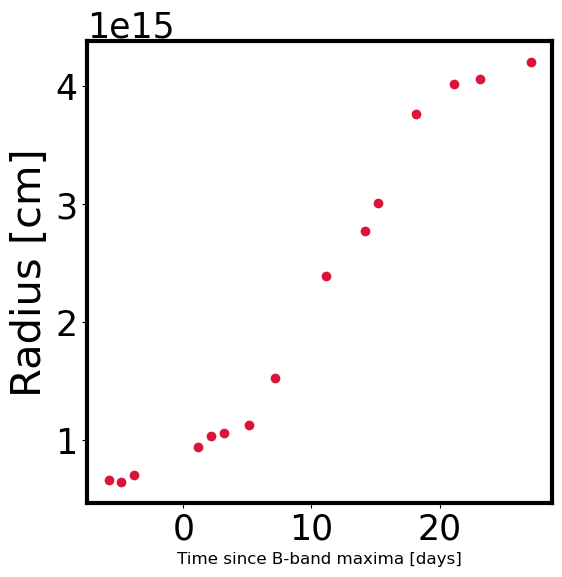

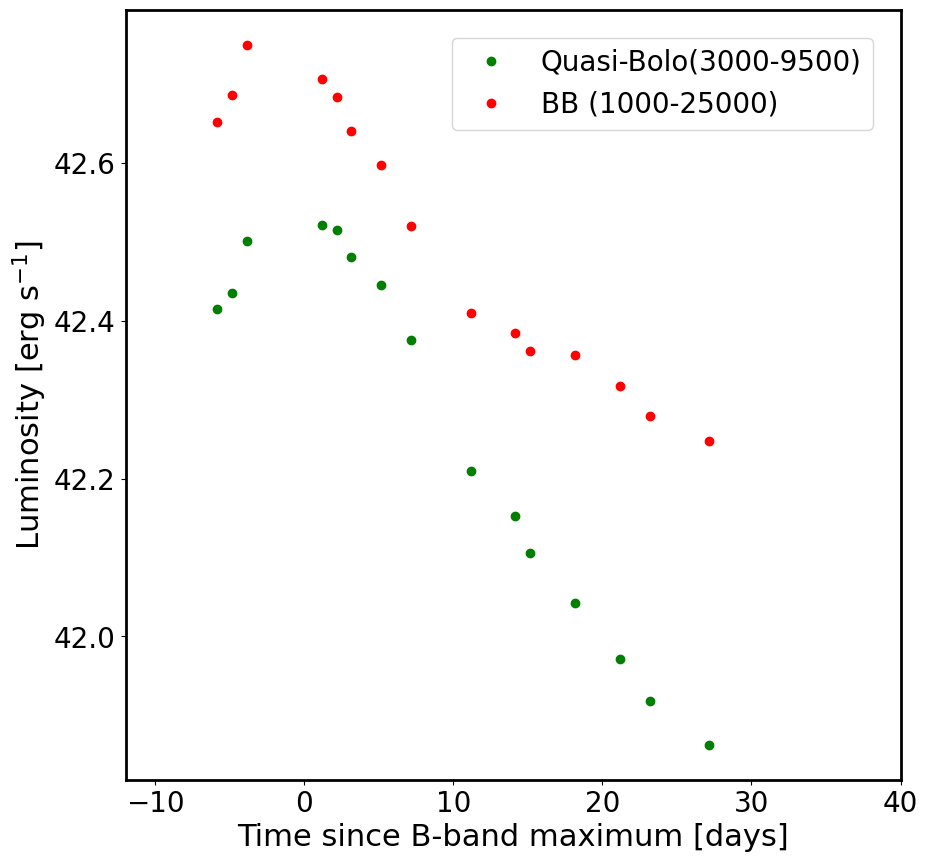

In [22]:
fig_app = plt.figure(figsize = (10, 10))
plt.rcParams['axes.linewidth'] = 2
ax = fig_app.add_subplot(111)
#plot_params('A', ax, ml_x = 10, mil_x = 2, ml_y = 1.0e42, mil_y = 0.2e42, invert=False)
legend_properties = {'size':15, 'weight':'book'}

plt.plot(lum_df_opt['Phase'], lum_df_opt['LogLum'], 'go', label='Quasi-Bolo(3000-9500)')
plt.plot(lum_df_opt['Phase'], lum_df_opt['Total_LogLum'], 'ro', label='BB (1000-25000)')
#plt.plot(lum_df_total['Texp'], lum_df_total['Lum'], 'ro', label='Total(1600-24000)')
plt.xlim(-12, 40)
#plt.ylim(0.1e42, 6.5e42)
plt.legend(fontsize=20, borderaxespad=1)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    #tick.label1.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
#ax.set_yscale("log")
ax.set_xlabel('Time since B-band maximum [days]', fontsize = 22)
ax.set_ylabel(r'$\rm Luminosity\ [erg\ s^{-1}]$', fontsize = 22);
plt.show();

In [13]:
#lum_df_opt

In [14]:
#plt.plot(lum_df_opt['Phase'], lum_df_opt['Temp'], 'o')

In [15]:
#plt.plot(lum_df_opt['Phase'], lum_df_opt['Radius'], 'o')

In [122]:
lum_df_opt['Lum'] = pd.to_numeric(lum_df_opt['Lum'])
lum_df_opt['Total_Lum'] = pd.to_numeric(lum_df_opt['Total_Lum'])
lum_df_opt['Lum_Err'] = pd.to_numeric(lum_df_opt['Lum_Err'])
lum_df_opt['Total_Lum_Err'] = pd.to_numeric(lum_df_opt['Total_Lum_Err'])
lum_df_opt['Lum_Ratio'] = lum_df_opt['Lum'] / lum_df_opt['Total_Lum']
lum_df_opt['Log_Lum_Err'] = lum_df_opt.apply(lambda x: (0.434*x['Lum_Err'])/x['Lum'], axis=1)
lum_df_opt['Total_LogLum_Err'] = lum_df_opt.apply(lambda x: (0.434*x['Total_Lum_Err'])/x['Total_Lum'], axis=1)

In [123]:
lum_df_opt

JD        Date   Phase           Lum       Lum_Err     LogLum  \
0   2459093.0  2020-08-31  -5.841  2.600000e+42  2.030000e+41  42.415376   
1   2459094.0  2020-09-01  -4.841  2.720000e+42  2.100000e+41  42.435132   
2   2459095.0  2020-09-02  -3.841  3.170000e+42  2.420000e+41  42.501139   
3   2459100.0  2020-09-07   1.159  3.330000e+42  2.700000e+41  42.521997   
4   2459101.0  2020-09-08   2.159  3.280000e+42  2.640000e+41   42.51557   
5   2459102.0  2020-09-09   3.159  3.020000e+42  2.420000e+41   42.48046   
6   2459104.0  2020-09-11   5.159  2.780000e+42  2.250000e+41  42.444761   
7   2459106.0  2020-09-13   7.159  2.370000e+42  1.940000e+41  42.375335   
8   2459110.0  2020-09-17  11.159  1.620000e+42  1.510000e+41  42.209035   
9   2459113.0  2020-09-20  14.159  1.420000e+42  1.350000e+41  42.153193   
10  2459114.0  2020-09-21  15.159  1.280000e+42  1.250000e+41  42.106008   
11  2459117.0  2020-09-24  18.159  1.100000e+42  1.120000e+41  42.042645   
12  2459120.0  2020-09-27  21.159  9.370000e+41  9.460000e+40   41.97156   
13  2459122.0  2020-09-29  23.159  8.290000e+41  8.520000e+40  41.918324   
14  2459126.0  2020-10-03  27.159  7.290000e+41  7.520000e+40  41.862778   

       Total_Lum Total_LogLum  Total_Lum_Err          Temp     TempErr  \
0   4.480000e+42    42.651347   6.320000e+41  11037.865943  848.699514   
1   4.860000e+42    42.686335   6.810000e+41  11404.289755  827.476602   
2   5.620000e+42    42.749881   6.320000e+41  11360.017311  646.993244   
3   5.080000e+42    42.705913   6.590000e+41   9529.732303  833.881653   
4   4.830000e+42    42.684198   5.230000e+41   8981.351234  678.643853   
5   4.370000e+42    42.640765   4.240000e+41   8642.645143  585.848433   
6   3.960000e+42    42.597376   3.310000e+41   8178.291911  440.907383   
7   3.310000e+42    42.519538   2.670000e+41    6727.28975  282.694377   
8   2.570000e+42    42.410002   4.540000e+41   5054.538494   335.44551   
9   2.430000e+42    42.384808   4.920000e+41   4628.423096  298.713999   
10  2.300000e+42    42.362351   4.990000e+41   4398.660014  270.172887   
11  2.270000e+42    42.356715   6.510000e+41   3938.691766  257.366673   
12  2.070000e+42    42.316932   6.690000e+41   3736.276126  248.617423   
13  1.910000e+42     42.27996   6.560000e+41   3648.762238  247.394952   
14  1.770000e+42    42.248044   6.630000e+41   3523.921773  242.922297   

          Radius Radius_Err  Lum_Ratio  Log_Lum_Err  Total_LogLum_Err  
0   6.570000e+14   7.14e+13   0.580357     0.033885          0.061225  
1   6.420000e+14   6.42e+13   0.559671     0.033507          0.060814  
2   6.950000e+14   5.47e+13   0.564057     0.033132          0.048806  
3   9.370000e+14   1.31e+14   0.655512     0.035189          0.056300  
4   1.030000e+15   1.31e+14   0.679089     0.034932          0.046994  
5   1.060000e+15   1.24e+14   0.691076     0.034777          0.042109  
6   1.120000e+15   1.11e+14   0.702020     0.035126          0.036276  
7   1.520000e+15   1.39e+14   0.716012     0.035526          0.035008  
8   2.390000e+15   4.59e+14   0.630350     0.040453          0.076668  
9   2.770000e+15   5.62e+14   0.584362     0.041261          0.087872  
10  3.010000e+15   6.14e+14   0.556522     0.042383          0.094159  
11  3.770000e+15   9.11e+14   0.484581     0.044189          0.124464  
12  4.020000e+15   1.04e+15   0.452657     0.043817          0.140264  
13  4.060000e+15   1.10e+15   0.434031     0.044604          0.149060  
14  4.210000e+15   1.20e+15   0.411864     0.044769          0.162566

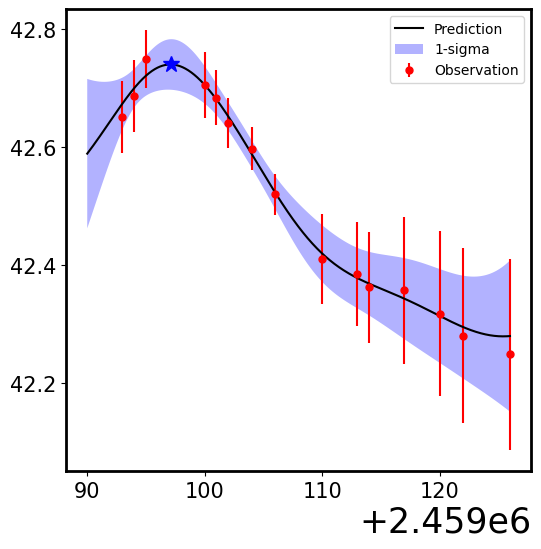

2459097.099099099 5.499625684464175e+42 5.436841941117171e+41


In [125]:
interp_values = interpolate_lc(lum_df_opt, amp = None, scale=10, diff_deg=3, plot=True,
              save_pred=False)
plt.show()
print (interp_values[3], interp_values[4], interp_values[5])

In [54]:
lum_df_opt.dtypes

JD               float64
Date              object
Phase             object
Lum              float64
Lum_Err          float64
LogLum            object
Total_Lum        float64
Total_LogLum      object
Total_Lum_Err    float64
Temp              object
TempErr           object
Radius           float64
Radius_Err        object
Lum_Ratio        float64
dtype: object

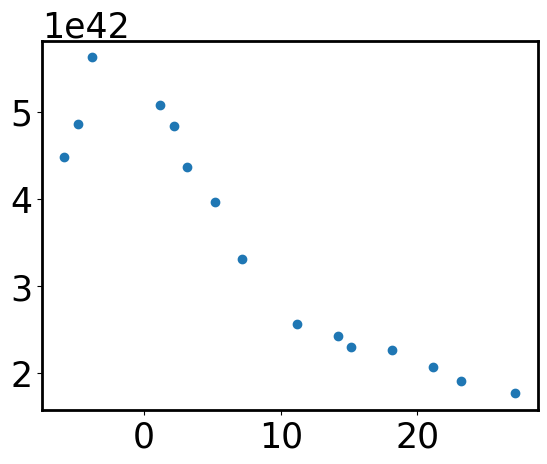

In [88]:
plt.plot(lum_df_opt['Phase'], lum_df_opt['Total_Lum'], 'o')
plt.show()

In [89]:
param_quasi = [0.1, 10, 36, 2459083]
#bnds = ((0.1,1), (0.5,1.4), (10,20))
soln_early_quasi=run_minimizer(log_likelihood=log_likelihood, df=lum_df_opt, 
                               x='JD', y='Lum', y_err='Lum_Err', param=param_quasi, seed=42)
print (soln_early_quasi)

[1.18470277e-01 9.33139033e+00 3.56899768e+01 2.45908611e+06]


In [113]:
sampler_early_quasi = run_MCMC(log_prob, log_prior, soln_early_quasi, lum_df_opt, 
                               'JD', 'Lum', 'Lum_Err', 4, 20, 1000)

100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


[1.18469348e-01 9.33122419e+00 3.56900344e+01 2.45908611e+06]


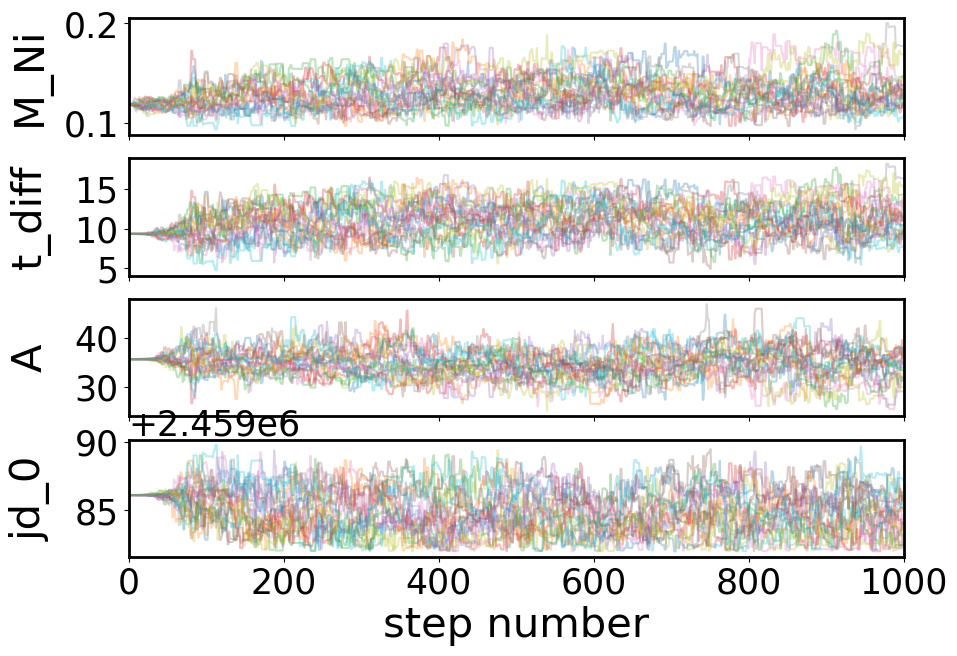

In [114]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

put_label_walk = ['M_Ni', 't_diff', 'A', 'jd_0']
new_max_quasi = run_walkers(sampler_early_quasi[0], put_label_walk, axes, 4)
print (new_max_quasi)
plt.show();

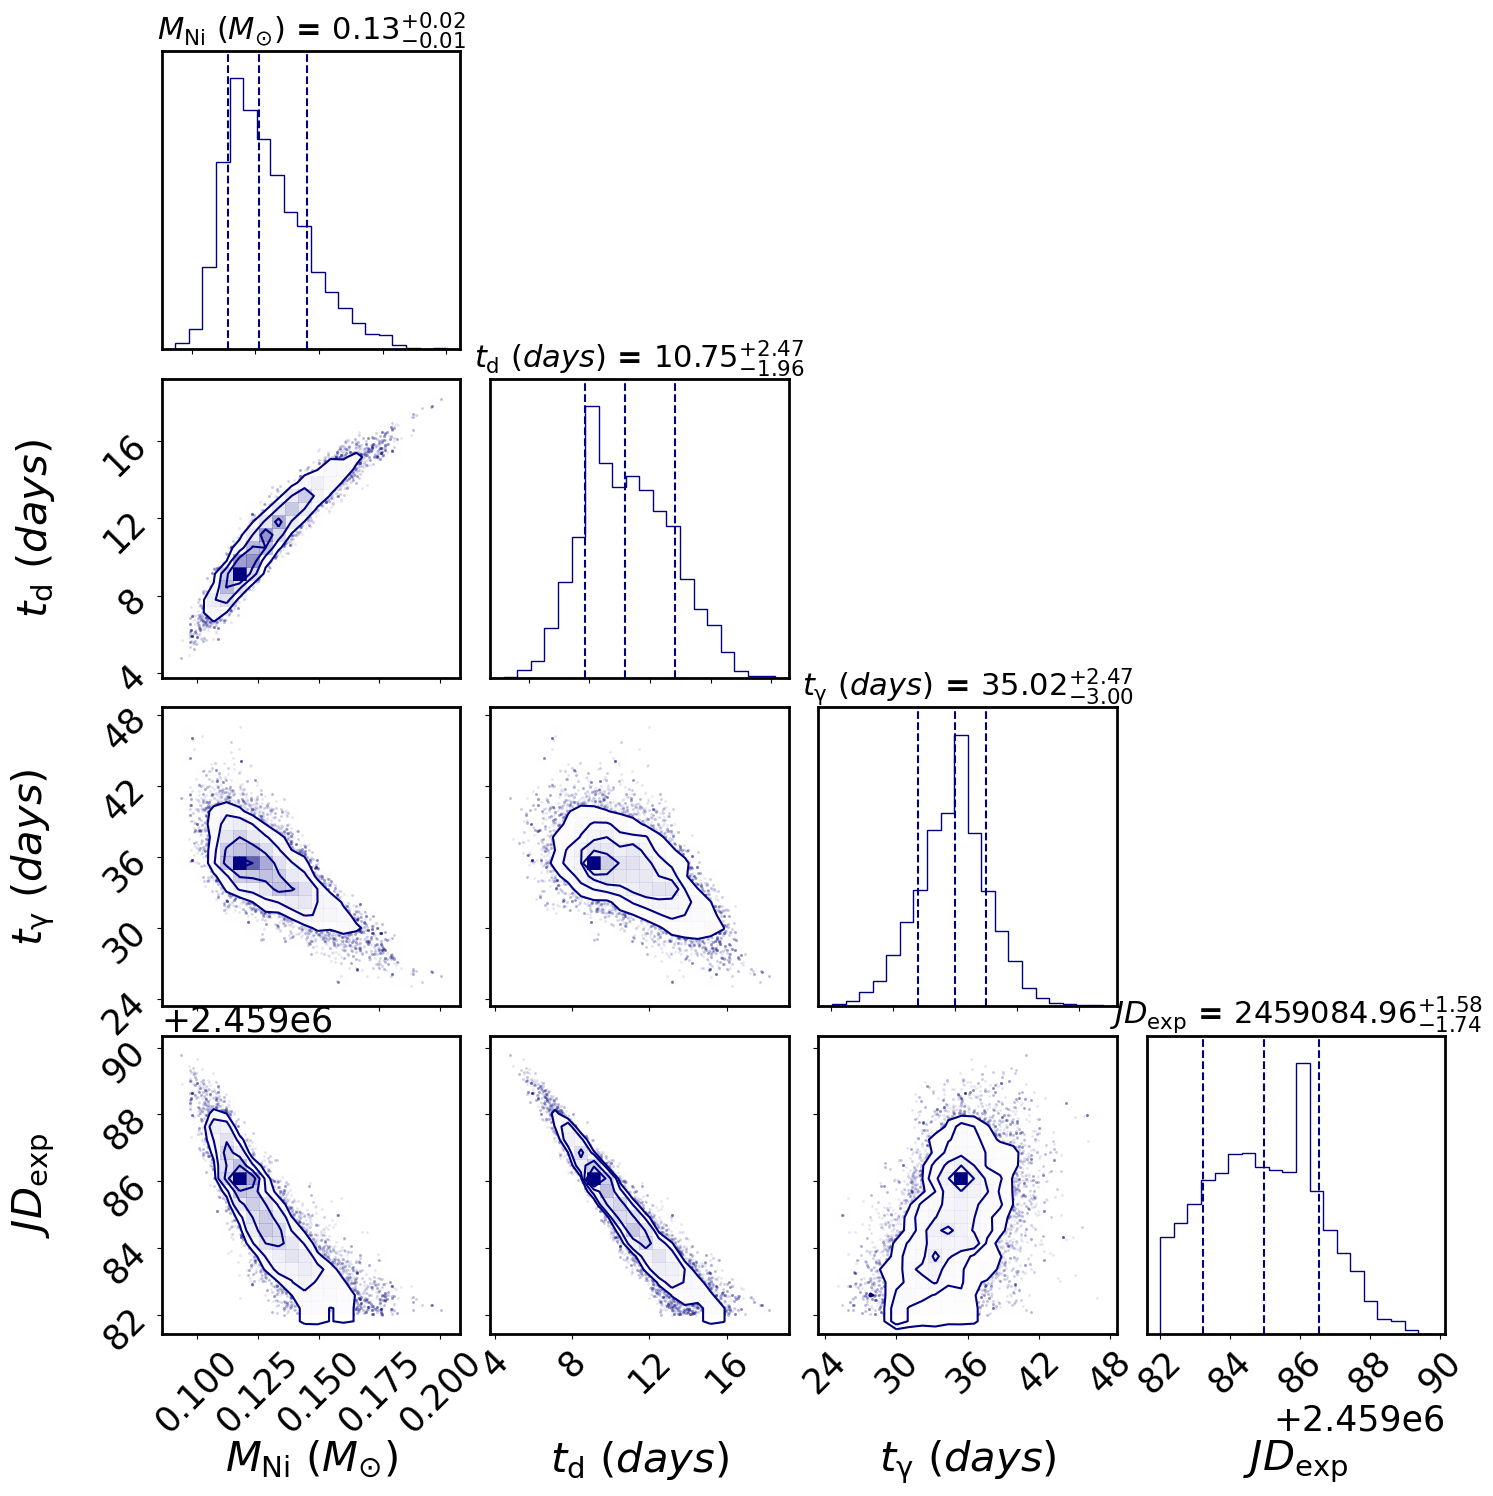

In [121]:
put_label_corn = [r'$M_{\rm Ni}\ (M_{\odot})$', r'$t_{\rm d}\ (days)$', r'$t_{\rm \gamma}\ (days)$', r'$JD_{\rm exp}$']

corner_plot(sampler_early_quasi, put_label_corn, soln_early_quasi, 4)
plt.savefig("/home/anirban/2020sck/Results/New_Results/Results/Plots/Corner.png", 
            dpi=200, bbox_inches='tight')
plt.show();

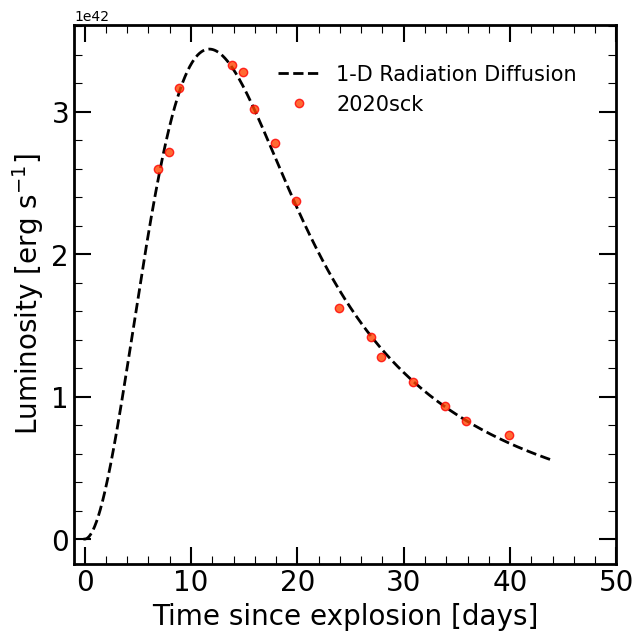

In [19]:
time_since_exp_quasi = np.linspace(2459086, 2459130, 1000)
lum_quasi = Rad_Diffusion(soln_early_quasi, time_since_exp_quasi)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot_params('A', ax, ml_x = 10, mil_x = 2, ml_y = 1e42, mil_y = 0.2e42, invert=False)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 1.5, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 0.8, labelsize = 12)
legend_properties = {'size':15, 'weight':'book'}
ax.set_xlim(-1, 50)
#ax.set_ylim(40, 43.5)
ax.plot(time_since_exp_quasi - soln_early_quasi[3], lum_quasi, 'k--', linewidth=2, label='1-D Radiation Diffusion')
#ax.errorbar(clipped_lum_df['JD'] - soln_early[3], clipped_lum_df['Lum'], yerr=clipped_lum_df['Lum_Err'], 
#            fmt='', ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, capsize=2, capthick=1, label='2020sck',
#           alpha = 0.8)

ax.plot(lum_df_opt['JD'] - soln_early_quasi[3], lum_df_opt['Lum'], 
            ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, label='2020sck',
           alpha = 0.8)
#ax.plot(lum_df_total['JD'] - soln_early[3], lum_df_total['Lum'], 'ro', label='Bolometry Data Points')
#ax.set_xlim(1, 30)
ax.set_xlabel('Time since explosion [days]', fontsize = 20)
ax.set_ylabel(r'Luminosity $[\rm erg\ s^{-1}]$', fontsize = 20)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
#ax.ticklabel_format(axis = 'y', useOffset=False, style='sci')

ax.legend(frameon= False, fancybox = False, shadow = True, framealpha=0.3, facecolor = 'white', 
         loc = 'upper right', prop = legend_properties, borderaxespad=1.5)

#chi_sq = cal_chisq(soln_early, lum_df_opt)
#print (chi_sq)


#ax.text(54, 1.2e43, r'$M_{Ni} = 0.61\ M_{\odot}$', fontsize=15);
#ax.text(54, 1.1e43, r'$t_{0} = 16.85\ d$', fontsize=15);
#ax.text(54, 1.0e43, r'$t_{\gamma} = 41.4\ d$', fontsize=15);
#ax.text(54, 0.9e43, r'$t_{d} = 13.38\ d$', fontsize=15);
#ax.text(54, 0.8e43, r'$\kappa = 0.11\ cm^{2}/g$', fontsize=15);
#ax.text(54, 0.7e43, r'$v = 9500\ km/s$', fontsize=15);
#ax.text(54, 0.6e43, r'$E_{k} = 0.65\ foe$', fontsize=15);
#ax.text(54, 0.5e43, r'$M_{ej} = 1.20\ M_{\odot}$', fontsize=15);
#ax.text(54, 0.38e43, r'$\chi^{2}/ \rm dof = 1.4$', fontsize=15);
#plt.savefig(save_results+"Bolometry_Arnett.png", dpi=500, bbox_inches='tight',
#           facecolor='white')


# In[101]:

plt.show()

In [20]:
model_df_quasi = pd.DataFrame(list(zip(time_since_exp_quasi, lum_quasi)),
               columns =['JD', 'Lum'])

print (np.max(lum_quasi))

#print (model_df_quasi)

3.4399799164417635e+42


In [21]:
samples = sampler_early_quasi[0].flatchain
ni = samples[:, 0]
t_lc = samples[:, 1]
t_gamma = samples[:, 2]
jd_exp = samples[:, 3]
#=======================================================================#
ni_mcmc = np.percentile(samples[:, 0], [16, 50, 84])
ni_q = np.diff(ni_mcmc)
mni, mni_upp, mni_low  = ni_mcmc[1], ni_q[0], ni_q[1]
#=======================================================================#
tlc_mcmc = np.percentile(samples[:, 1], [16, 50, 84])
tlc_q = np.diff(tlc_mcmc)
tlc, tlc_upp, tlc_low  = tlc_mcmc[1], tlc_q[0], tlc_q[1]
#=======================================================================#
tg_mcmc = np.percentile(samples[:, 2], [16, 50, 84])
tg_q = np.diff(tg_mcmc)
tg, tg_upp, tg_low  = tg_mcmc[1], tg_q[0], tg_q[1]
#=======================================================================#
jd_mcmc = np.percentile(samples[:, 3], [16, 50, 84])
jd_q = np.diff(jd_mcmc)
jd, jd_upp, jd_low  = jd_mcmc[1], jd_q[0], jd_q[1]
#=======================================================================#

In [23]:
# Save parameters
file_name = save_results+'Arnett_model.dat'
if os.path.exists(file_name):
    os.remove(file_name)
f = open(file_name, 'w')
f.write("This file contains the parameters of the Arnett model fit for object %s\n\n"%Object)
f.write("#===================================================================#\n\n")
f.write("#===================================================================#\n\n")
f.write("The Nickel mass is: %f + %f - %f\n\n"%(soln_early_quasi[0], mni_upp, mni_low))
f.write("The light curve time scale is: %f + %f - %f\n\n"%(soln_early_quasi[1], tlc_upp, tlc_low))
f.write("The gamma ray leaking time scale is: %f + %f - %f\n\n"%(soln_early_quasi[2], tg_upp, tg_low))
f.write("The JD of explosion is: %f + %f - %f\n\n"%(soln_early_quasi[3], jd_upp, jd_low))
f.write("#===================================================================#\n\n")
f.write("#===================================================================#\n\n")
f.close()

In [30]:
#import csv
#with open(save_results+'model_bol.csv', 'w') as f:
#    writer = csv.writer(f, delimiter='\t')
#    writer.writerows(zip(time_since_exp, lum))
    
#f.close()    

In [27]:
param_uvoir = [0.1, 10, 1000, 2459085]
#bnds = ((0.1,1), (0.5,1.4), (10,20))
soln_early_uvoir=run_minimizer(log_likelihood=log_likelihood, df=lum_df_opt, 
                               x='JD', y='Total_Lum', y_err='Total_Lum_Err', 
                               param=param_uvoir, seed=42)
print (soln_early_uvoir)

[1.63556592e-01 6.74058913e+00 1.67681559e+04 2.45908744e+06]


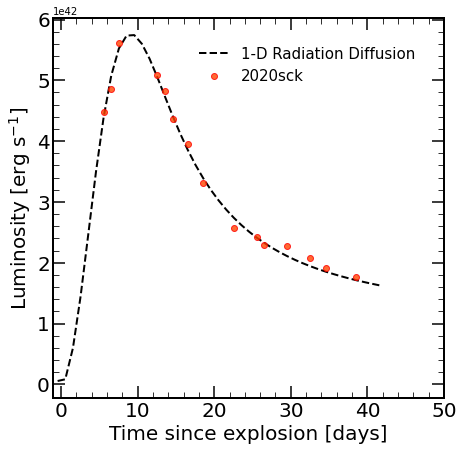

In [20]:
time_since_exp_uvoir = np.arange(2459087, 2459130)
lum_uvoir = Rad_Diffusion(soln_early_uvoir, time_since_exp_uvoir)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plot_params('A', ax, ml_x = 10, mil_x = 2, ml_y = 1e42, mil_y = 0.2e42, invert=False)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 1.5, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 0.8, labelsize = 12)
legend_properties = {'size':15, 'weight':'book'}
ax.set_xlim(-1, 50)
#ax.set_ylim(40, 43.5)
ax.plot(time_since_exp_uvoir - soln_early_uvoir[3], lum_uvoir, 'k--', linewidth=2, label='1-D Radiation Diffusion')
#ax.errorbar(clipped_lum_df['JD'] - soln_early[3], clipped_lum_df['Lum'], yerr=clipped_lum_df['Lum_Err'], 
#            fmt='', ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, capsize=2, capthick=1, label='2020sck',
#           alpha = 0.8)

ax.plot(lum_df_opt['JD'] - soln_early_uvoir[3], lum_df_opt['Total_Lum'], 
            ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, label='2020sck',
           alpha = 0.8)
#ax.plot(lum_df_total['JD'] - soln_early[3], lum_df_total['Lum'], 'ro', label='Bolometry Data Points')
#ax.set_xlim(1, 30)
ax.set_xlabel('Time since explosion [days]', fontsize = 20)
ax.set_ylabel(r'Luminosity $[\rm erg\ s^{-1}]$', fontsize = 20)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 20)
    
#ax.ticklabel_format(axis = 'y', useOffset=False, style='sci')

ax.legend(frameon= False, fancybox = False, shadow = True, framealpha=0.3, facecolor = 'white', 
         loc = 'upper right', prop = legend_properties, borderaxespad=1.5)

#chi_sq = cal_chisq(soln_early, lum_df_opt)
#print (chi_sq)


#ax.text(54, 1.2e43, r'$M_{Ni} = 0.61\ M_{\odot}$', fontsize=15);
#ax.text(54, 1.1e43, r'$t_{0} = 16.85\ d$', fontsize=15);
#ax.text(54, 1.0e43, r'$t_{\gamma} = 41.4\ d$', fontsize=15);
#ax.text(54, 0.9e43, r'$t_{d} = 13.38\ d$', fontsize=15);
#ax.text(54, 0.8e43, r'$\kappa = 0.11\ cm^{2}/g$', fontsize=15);
#ax.text(54, 0.7e43, r'$v = 9500\ km/s$', fontsize=15);
#ax.text(54, 0.6e43, r'$E_{k} = 0.65\ foe$', fontsize=15);
#ax.text(54, 0.5e43, r'$M_{ej} = 1.20\ M_{\odot}$', fontsize=15);
#ax.text(54, 0.38e43, r'$\chi^{2}/ \rm dof = 1.4$', fontsize=15);
#plt.savefig(save_results+"Bolometry_Arnett_BB.png", dpi=500, bbox_inches='tight',
#facecolor='white')


In [21]:
model_df_uvoir = pd.DataFrame(list(zip(time_since_exp_uvoir, lum_uvoir)),
               columns =['JD', 'Lum'])

print (np.max(lum_uvoir))


5.743877364244949e+42


[1.74332922e-01 7.65053718e+00 1.71788084e+04 2.45908647e+06]


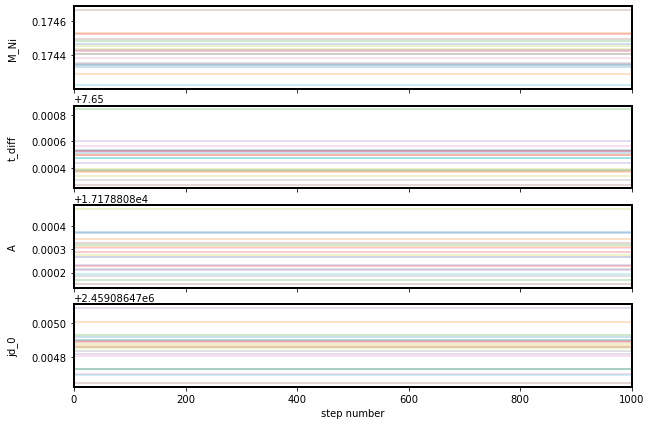

In [114]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

put_label_walk = ['M_Ni', 't_diff', 'A', 'jd_0']
new_max = run_walkers(sampler_early[0], put_label_walk, axes, 4)
print (new_max)

In [117]:
import csv
with open(save_results+'model_bol_BB.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(time_since_exp, lum))
    
f.close()    

In [32]:
sampler_early = run_MCMC(log_prob, log_prior, soln_early_uvoir, lum_df_opt, 
                         'JD', 'Total_Lum', 'Total_Lum_Err', 4, 20, 500)

100%|██████████| 500/500 [02:00<00:00,  4.16it/s]


[1.63555563e-01 6.74048852e+00 1.59005442e+04 2.45908744e+06]


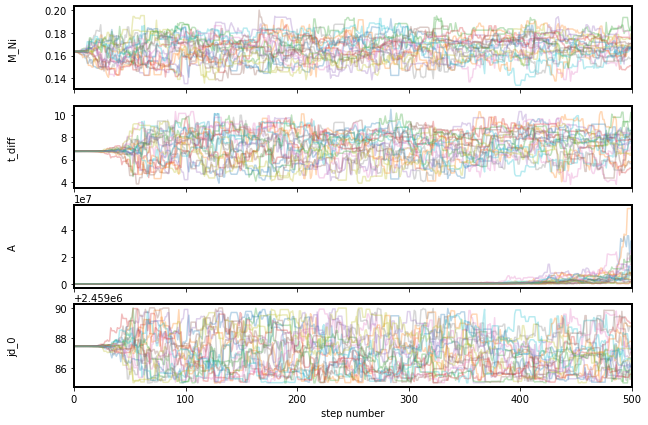

In [33]:
ig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

put_label_walk = ['M_Ni', 't_diff', 'A', 'jd_0']
new_max_uvoir = run_walkers(sampler_early[0], put_label_walk, axes, 4)
print (new_max_uvoir)

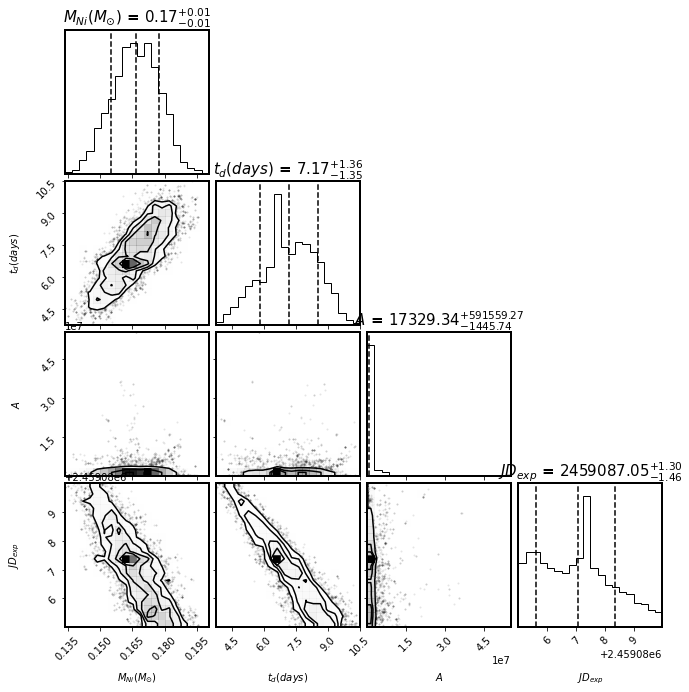

In [34]:
put_label_corn = [r'$M_{Ni}(M_{\odot})$', r'$t_{d}(days)$', r'$A$', r'$JD_{exp}$']

corner_plot(sampler_early, put_label_corn, soln_early_uvoir, 4)

In [53]:
samples = sampler_early[0].flatchain
ni = samples[:, 0]
t_lc = samples[:, 1]
t_gamma = samples[:, 2]
jd_exp = samples[:, 3]
#=======================================================================#
ni_mcmc = np.percentile(samples[:, 0], [16, 50, 84])
ni_q = np.diff(ni_mcmc)
mni, mni_upp, mni_low  = ni_mcmc[1], ni_q[0], ni_q[1]
#=======================================================================#
tlc_mcmc = np.percentile(samples[:, 1], [16, 50, 84])
tlc_q = np.diff(tlc_mcmc)
tlc, tlc_upp, tlc_low  = tlc_mcmc[1], tlc_q[0], tlc_q[1]
#=======================================================================#
tg_mcmc = np.percentile(samples[:, 2], [16, 50, 84])
tg_q = np.diff(tg_mcmc)
tg, tg_upp, tg_low  = tg_mcmc[1], tg_q[0], tg_q[1]
#=======================================================================#
jd_mcmc = np.percentile(samples[:, 3], [16, 50, 84])
jd_q = np.diff(jd_mcmc)
jd, jd_upp, jd_low  = jd_mcmc[1], jd_q[0], jd_q[1]
#=======================================================================#

In [54]:
# Save parameters
file_name = save_results+'Arnett_model_UVOIR.dat'
if os.path.exists(file_name):
    os.remove(file_name)
f = open(file_name, 'w')
f.write("This file contains the parameters of the Arnett model fit for object %s\n\n"%Object)
f.write("#===================================================================#\n\n")
f.write("#===================================================================#\n\n")
f.write("The Nickel mass is: %f + %f - %f\n\n"%(soln_early[0], mni_upp, mni_low))
f.write("The light curve time scale is: %f + %f - %f\n\n"%(soln_early[1], tlc_upp, tlc_low))
f.write("The gamma ray leaking time scale is: %f + %f - %f\n\n"%(soln_early[2], tg_upp, tg_low))
f.write("The JD of explosion is: %f + %f - %f\n\n"%(soln_early[3], jd_upp, jd_low))
f.write("#===================================================================#\n\n")
f.write("#===================================================================#\n\n")
f.close()

In [17]:
import csv
with open(save_results+'model_bol_BB.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(zip(time_since_exp, lum))
    
f.close()    

In [40]:
# Plot 2020sck Bolometry with other models

In [35]:
#model_quasi = save_results + 'model_bol.csv'
#model_bb = save_results + 'model_bol_BB.csv'

#odel_quasi_df = pd.read_csv(model_quasi, sep=',')
#model_bb_df = pd.read_csv(model_bb, sep=',', names=['JD', 'Lum'], engine='python')
#model_bb_df['LogLum'] = model_bb_df['Lum'].apply(lambda x: np.log10(x))

#rint (model_bb_df)

In [30]:
#model_bb_df['LogLum'] = pd.to_numeric(model_bb_df['LogLum'])
#model_bb_df['JD'] = pd.to_numeric(model_bb_df['JD'])
#print (model_bb_df)
#lum_df_opt['Total_Lum'] = pd.to_numeric(lum_df_opt['Total_Lum'])
#lum_df_opt['Lum_Err'] = pd.to_numeric(lum_df_opt['Lum_Err'])
#lum_df_opt['Total_Lum_Err'] = pd.to_numeric(lum_df_opt['Total_Lum_Err'])

In [26]:
N3_def_file = '/home/anirban/2020sck/Results/def_2014_n3def_lightcurve.dat'
N3_def_df = pd.read_csv(N3_def_file, sep='\s+', names= ['Texp', 'Lum'], engine='python')
N5_def_file = '/home/anirban/2020sck/Results/def_2014_n5def_lightcurve.dat'
N5_def_df = pd.read_csv(N5_def_file, sep='\s+', names= ['Texp', 'Lum'], engine='python')
N10_def_file = '/home/anirban/2020sck/Results/def_2014_n10def_lightcurve.dat'
N10_def_df = pd.read_csv(N10_def_file, sep='\s+', names= ['Texp', 'Lum'], engine='python')
N20_def_file = '/home/anirban/2020sck/Results/def_2014_n20def_lightcurve.dat'
N20_def_df = pd.read_csv(N20_def_file, sep='\s+', names= ['Texp', 'Lum'], engine='python')


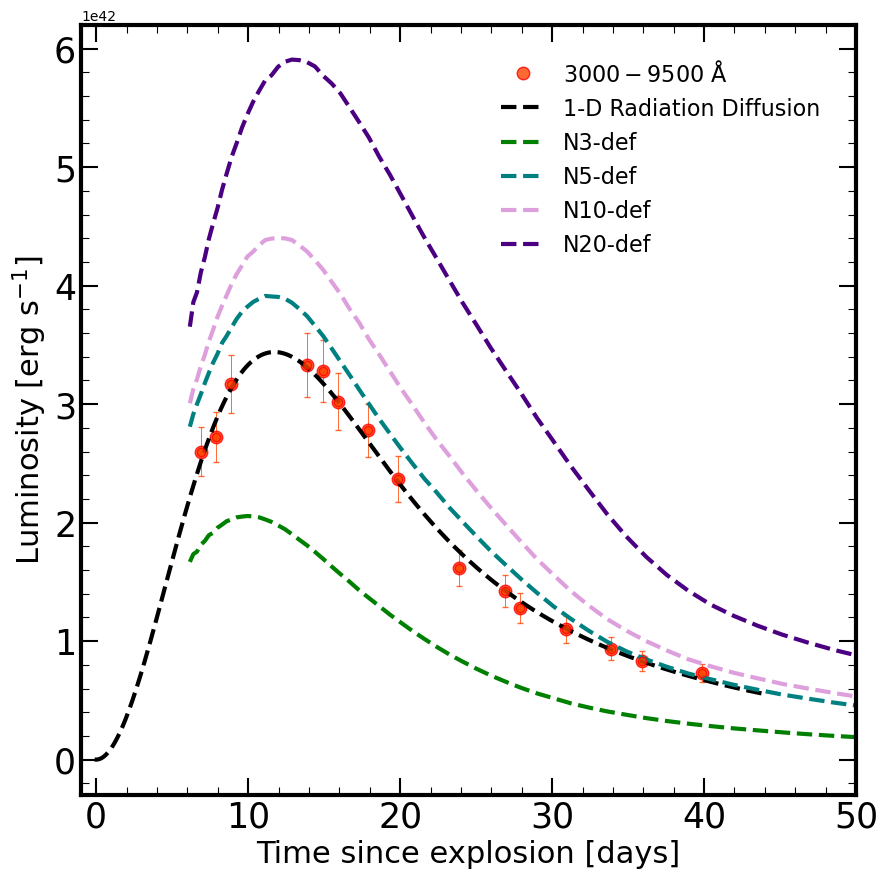

In [41]:
#time_since_exp = np.arange(2459087, 2459130)
#lum = Rad_Diffusion(soln_early, time_since_exp)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot_params('A', ax, ml_x = 10, mil_x = 2, ml_y = 1e42, mil_y = 0.2e42, invert=False)
ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 1.5, labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 0.8, labelsize = 12)
legend_properties = {'size':16, 'weight':'book'}
ax.set_xlim(-1, 50)
#ax.set_ylim(40, 43.5)



ax.plot(lum_df_opt['JD'] - soln_early_quasi[3], lum_df_opt['Lum'], 
            ms = 9, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, label=r'$\rm 3000-9500\ \AA$',
           alpha = 0.8)
ax.errorbar(lum_df_opt['JD'] - soln_early_quasi[3], lum_df_opt['Lum'], yerr=lum_df_opt['Lum_Err'], 
            fmt='', ms = 6, marker= 'o', c='orangered', mec = 'red', ls='', lw=0.7, capsize=2, capthick=1,
           alpha = 0.8, label='__no_legend__')

#ax.plot(lum_df_opt['JD'] - soln_early_uvoir[3], lum_df_opt['Total_Lum'], 
#        ms = 9, marker= 'o', c='navy', mec = 'blue', ls='', lw=0.7,
#           alpha = 0.8, label=r'$\rm Blackbody$')

#ax.errorbar(lum_df_opt['JD'] - soln_early_uvoir[3], lum_df_opt['Total_Lum'], 
#            yerr=lum_df_opt['Total_Lum_Err'], fmt='', ms = 6, marker= 'o', 
#            c='navy', mec = 'blue', ls='', lw=0.7, capsize=2, capthick=1,
#           alpha = 0.8, label='__no_legend__')


ax.plot(time_since_exp_quasi - soln_early_quasi[3], lum_quasi, 'k--', linewidth=3, label='1-D Radiation Diffusion')
#ax.plot(time_since_exp_uvoir - soln_early_uvoir[3], lum_uvoir, 'k--', linewidth=3)
#ax.plot(lum_df_total['JD'] - soln_early[3], lum_df_total['Lum'], 'ro', label='Bolometry Data Points')
#ax.set_xlim(1, 30)

    
#ax.ticklabel_format(axis = 'y', useOffset=False, style='sci')



#chi_sq = cal_chisq(soln_early, lum_df_opt)
#print (chi_sq)

ax.plot(N3_def_df['Texp'], N3_def_df['Lum'], '--', color = 'green', lw=3, label='N3-def')
ax.plot(N5_def_df['Texp'], N5_def_df['Lum'], '--', color = 'teal', lw=3,  label='N5-def')
ax.plot(N10_def_df['Texp'], N10_def_df['Lum'], '--', color = 'plum', lw=3, label='N10-def')
ax.plot(N20_def_df['Texp'], N20_def_df['Lum'], '--', color = 'indigo', lw=3, label='N20-def')

ax.legend(frameon= False, fancybox = False, shadow = True, framealpha=0.3, facecolor = 'white', 
         loc = 'upper right', prop = legend_properties, borderaxespad=1.2)

ax.set_xlabel('Time since explosion [days]', fontsize = 22)
ax.set_ylabel(r'Luminosity $[\rm erg\ s^{-1}]$', fontsize = 22)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 25)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 25)

plt.savefig("/home/anirban/2020sck/Results/New_Results/Results/Plots/Bolometric_LC.png", dpi=100, bbox_inches='tight',
          facecolor='white')

plt.show();

In [51]:
#model_bb_df

In [19]:
lum

array([5.55387000e+40, 5.33643654e+40, 5.12343565e+40, ...,
       1.60497293e+42, 1.60476622e+42, 1.60455961e+42])

In [24]:
time_since_exp

array([2459087, 2459088, 2459089, 2459090, 2459091, 2459092, 2459093,
       2459094, 2459095, 2459096, 2459097, 2459098, 2459099, 2459100,
       2459101, 2459102, 2459103, 2459104, 2459105, 2459106, 2459107,
       2459108, 2459109, 2459110, 2459111, 2459112, 2459113, 2459114,
       2459115, 2459116, 2459117, 2459118, 2459119, 2459120, 2459121,
       2459122, 2459123, 2459124, 2459125, 2459126, 2459127, 2459128,
       2459129])

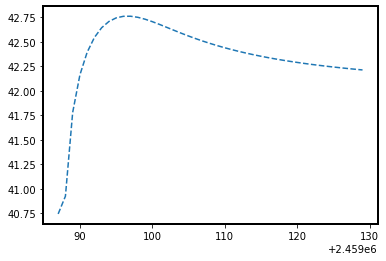

In [45]:
plt.plot(model_bb_df['JD'], model_bb_df['LogLum'], '--')

In [59]:
lum_df_opt

JD        Date   Phase           Lum       Lum_Err     LogLum  \
0   2459093.0  2020-08-31  -5.841  2.600000e+42  2.030000e+41  42.415376   
1   2459094.0  2020-09-01  -4.841  2.720000e+42  2.100000e+41  42.435132   
2   2459095.0  2020-09-02  -3.841  3.170000e+42  2.420000e+41  42.501139   
3   2459100.0  2020-09-07   1.159  3.330000e+42  2.700000e+41  42.521997   
4   2459101.0  2020-09-08   2.159  3.280000e+42  2.640000e+41   42.51557   
5   2459102.0  2020-09-09   3.159  3.020000e+42  2.420000e+41   42.48046   
6   2459104.0  2020-09-11   5.159  2.780000e+42  2.250000e+41  42.444761   
7   2459106.0  2020-09-13   7.159  2.370000e+42  1.940000e+41  42.375335   
8   2459110.0  2020-09-17  11.159  1.620000e+42  1.510000e+41  42.209035   
9   2459113.0  2020-09-20  14.159  1.420000e+42  1.350000e+41  42.153193   
10  2459114.0  2020-09-21  15.159  1.280000e+42  1.250000e+41  42.106008   
11  2459117.0  2020-09-24  18.159  1.100000e+42  1.120000e+41  42.042645   
12  2459120.0  2020-09-27  21.159  9.370000e+41  9.460000e+40   41.97156   
13  2459122.0  2020-09-29  23.159  8.290000e+41  8.520000e+40  41.918324   
14  2459126.0  2020-10-03  27.159  7.290000e+41  7.520000e+40  41.862778   

       Total_Lum Total_LogLum  Total_Lum_Err          Temp     TempErr  \
0   4.480000e+42    42.651347   6.320000e+41  11037.865943  848.699514   
1   4.860000e+42    42.686335   6.810000e+41  11404.289755  827.476602   
2   5.620000e+42    42.749881   6.320000e+41  11360.017311  646.993244   
3   5.080000e+42    42.705913   6.590000e+41   9529.732303  833.881653   
4   4.830000e+42    42.684198   5.230000e+41   8981.351234  678.643853   
5   4.370000e+42    42.640765   4.240000e+41   8642.645143  585.848433   
6   3.960000e+42    42.597376   3.310000e+41   8178.291911  440.907383   
7   3.310000e+42    42.519538   2.670000e+41    6727.28975  282.694377   
8   2.570000e+42    42.410002   4.540000e+41   5054.538494   335.44551   
9   2.430000e+42    42.384808   4.920000e+41   4628.423096  298.713999   
10  2.300000e+42    42.362351   4.990000e+41   4398.660014  270.172887   
11  2.270000e+42    42.356715   6.510000e+41   3938.691766  257.366673   
12  2.070000e+42    42.316932   6.690000e+41   3736.276126  248.617423   
13  1.910000e+42     42.27996   6.560000e+41   3648.762238  247.394952   
14  1.770000e+42    42.248044   6.630000e+41   3523.921773  242.922297   

          Radius Radius_Err  
0   6.570000e+14   7.14e+13  
1   6.420000e+14   6.42e+13  
2   6.950000e+14   5.47e+13  
3   9.370000e+14   1.31e+14  
4   1.030000e+15   1.31e+14  
5   1.060000e+15   1.24e+14  
6   1.120000e+15   1.11e+14  
7   1.520000e+15   1.39e+14  
8   2.390000e+15   4.59e+14  
9   2.770000e+15   5.62e+14  
10  3.010000e+15   6.14e+14  
11  3.770000e+15   9.11e+14  
12  4.020000e+15   1.04e+15  
13  4.060000e+15   1.10e+15  
14  4.210000e+15   1.20e+15

In [40]:
soln_early_quasi[3]

2459086.1097091683

In [41]:
soln_early_uvoir[3]

2459087.440214038

In [44]:
lum_df_opt['JD'] - soln_early_uvoir[3]

0      5.559786
1      6.559786
2      7.559786
3     12.559786
4     13.559786
5     14.559786
6     16.559786
7     18.559786
8     22.559786
9     25.559786
10    26.559786
11    29.559786
12    32.559786
13    34.559786
14    38.559786
Name: JD, dtype: float64

In [45]:
lum_df_opt['JD'] - soln_early_quasi[3]

0      6.890291
1      7.890291
2      8.890291
3     13.890291
4     14.890291
5     15.890291
6     17.890291
7     19.890291
8     23.890291
9     26.890291
10    27.890291
11    30.890291
12    33.890291
13    35.890291
14    39.890291
Name: JD, dtype: float64

In [68]:
lum_df_opt

JD        Date   Phase           Lum       Lum_Err     LogLum  \
0   2459093.0  2020-08-31  -5.841  2.600000e+42  2.030000e+41  42.415376   
1   2459094.0  2020-09-01  -4.841  2.720000e+42  2.100000e+41  42.435132   
2   2459095.0  2020-09-02  -3.841  3.170000e+42  2.420000e+41  42.501139   
3   2459100.0  2020-09-07   1.159  3.330000e+42  2.700000e+41  42.521997   
4   2459101.0  2020-09-08   2.159  3.280000e+42  2.640000e+41   42.51557   
5   2459102.0  2020-09-09   3.159  3.020000e+42  2.420000e+41   42.48046   
6   2459104.0  2020-09-11   5.159  2.780000e+42  2.250000e+41  42.444761   
7   2459106.0  2020-09-13   7.159  2.370000e+42  1.940000e+41  42.375335   
8   2459110.0  2020-09-17  11.159  1.620000e+42  1.510000e+41  42.209035   
9   2459113.0  2020-09-20  14.159  1.420000e+42  1.350000e+41  42.153193   
10  2459114.0  2020-09-21  15.159  1.280000e+42  1.250000e+41  42.106008   
11  2459117.0  2020-09-24  18.159  1.100000e+42  1.120000e+41  42.042645   
12  2459120.0  2020-09-27  21.159  9.370000e+41  9.460000e+40   41.97156   
13  2459122.0  2020-09-29  23.159  8.290000e+41  8.520000e+40  41.918324   
14  2459126.0  2020-10-03  27.159  7.290000e+41  7.520000e+40  41.862778   

       Total_Lum Total_LogLum  Total_Lum_Err          Temp     TempErr  \
0   4.480000e+42    42.651347   6.320000e+41  11037.865943  848.699514   
1   4.860000e+42    42.686335   6.810000e+41  11404.289755  827.476602   
2   5.620000e+42    42.749881   6.320000e+41  11360.017311  646.993244   
3   5.080000e+42    42.705913   6.590000e+41   9529.732303  833.881653   
4   4.830000e+42    42.684198   5.230000e+41   8981.351234  678.643853   
5   4.370000e+42    42.640765   4.240000e+41   8642.645143  585.848433   
6   3.960000e+42    42.597376   3.310000e+41   8178.291911  440.907383   
7   3.310000e+42    42.519538   2.670000e+41    6727.28975  282.694377   
8   2.570000e+42    42.410002   4.540000e+41   5054.538494   335.44551   
9   2.430000e+42    42.384808   4.920000e+41   4628.423096  298.713999   
10  2.300000e+42    42.362351   4.990000e+41   4398.660014  270.172887   
11  2.270000e+42    42.356715   6.510000e+41   3938.691766  257.366673   
12  2.070000e+42    42.316932   6.690000e+41   3736.276126  248.617423   
13  1.910000e+42     42.27996   6.560000e+41   3648.762238  247.394952   
14  1.770000e+42    42.248044   6.630000e+41   3523.921773  242.922297   

          Radius Radius_Err  Lum_Ratio  
0   6.570000e+14   7.14e+13   0.580357  
1   6.420000e+14   6.42e+13   0.559671  
2   6.950000e+14   5.47e+13   0.564057  
3   9.370000e+14   1.31e+14   0.655512  
4   1.030000e+15   1.31e+14   0.679089  
5   1.060000e+15   1.24e+14   0.691076  
6   1.120000e+15   1.11e+14   0.702020  
7   1.520000e+15   1.39e+14   0.716012  
8   2.390000e+15   4.59e+14   0.630350  
9   2.770000e+15   5.62e+14   0.584362  
10  3.010000e+15   6.14e+14   0.556522  
11  3.770000e+15   9.11e+14   0.484581  
12  4.020000e+15   1.04e+15   0.452657  
13  4.060000e+15   1.10e+15   0.434031  
14  4.210000e+15   1.20e+15   0.411864

In [40]:
kappa = 0.10   # constant optical opacity (cm^2/g)
v_ph = 5.0e8   # velocity in cm/s
t_d = 9.32    # diffusion time in days
td_err_upper = 1.36
td_err_lower = 0.95
Mej = (0.5 * beta * c * v_ph * (t_d* 86400)**2)/kappa   # ejecta mass in gm
norm_Mej = (Mej/M_sun)     # ejecta mass in solar mass
normMej_err_upper = (2*norm_Mej*td_err_upper)/t_d
normMej_err_lower = (2*norm_Mej*td_err_lower)/t_d

EK = 0.3 * Mej * v_ph**2   # kinetic energy in erg/s
norm_EK = EK/10**51        # kinetic energy in foe
normEK_err_upper = (norm_EK*normMej_err_upper)/norm_Mej
normEK_err_lower = (norm_EK*normMej_err_lower)/norm_Mej
print ('#=======================================================#')
print ('The ejected mass is %f + %f - %f:'%(norm_Mej, normMej_err_upper, normMej_err_lower))
print ('The kinetic energy of explosion is %f + %f - %f:'%(norm_EK, 
                                                           normEK_err_upper, normEK_err_lower))
print ('The diffusion time is:', t_d)
print ('#=======================================================#')
print (beta)

#=======================================================#
The ejected mass is 0.337182 + 0.098405 - 0.068739:
The kinetic energy of explosion is 0.050299 + 0.014680 - 0.010254:
The diffusion time is: 9.32
#=======================================================#
13.8
